# Sistemas de Recomemdação

## Importar pacotes e bases

### 1. Imports e Configuração Geral

In [2]:
# ===============================================
# SISTEMA DE RECOMENDAÇÃO HÍBRIDO — TCC
# ===============================================

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import correlation, jaccard
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import locale
locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

### 2. Carregamento

In [3]:
# Leitura dos dados pré-tratados
ratings_original = pd.read_csv("bases/user_ratings.csv")
# Carregar todas as colunas para permitir uso de cat*
games = pd.read_csv("bases/games.csv")
mechanics = pd.read_csv("bases/mechanics.csv")

### 3. Limpeza, tratamentos e filtragem

In [4]:
# Consolidar duplicatas: média das notas por usuário e jogo
ratings_original = ratings_original.groupby(['Username', 'BGGId'], as_index=False)['Rating'].mean()


In [5]:
# --- Filtrar jogos modernos ---
games = games[games['YearPublished'] >= 1990]
ratings_original = ratings_original[ratings_original['BGGId'].isin(games['BGGId'])]

# Consolidar duplicatas: média das notas por usuário e jogo
# ratings = ratings.groupby(['Username', 'BGGId'], as_index=False)['Rating'].mean()

# --- Amostra leve ---
sample_users = ratings_original['Username'].value_counts().head(5000).index
sample_games = ratings_original['BGGId'].value_counts().head(2000).index
ratings = ratings_original[ratings_original['Username'].isin(sample_users) & ratings_original['BGGId'].isin(sample_games)]


print(f"Dimensões finais da base: {ratings.shape}")
print(f"Usuários únicos: {ratings['Username'].nunique()}")
print(f"Jogos únicos: {ratings['BGGId'].nunique()}")

Dimensões finais da base: (2217792, 3)
Usuários únicos: 5000
Jogos únicos: 2000


### 4. Analise Exploratória dos dados

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

import locale

# Set locale to German (comma for decimal, dot for thousands)
# Use 'de_DE.UTF-8' on Linux/macOS, 'German_Germany.1252' on Windows
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

plt.rcParams['axes.formatter.use_locale'] = True

--- Estatísticas Descritivas das Notas ---
Média: 6.9309
Mediana: 7.0000
Assimetria (Skewness): -0.5289
Curtose (Kurtosis): 0.9837


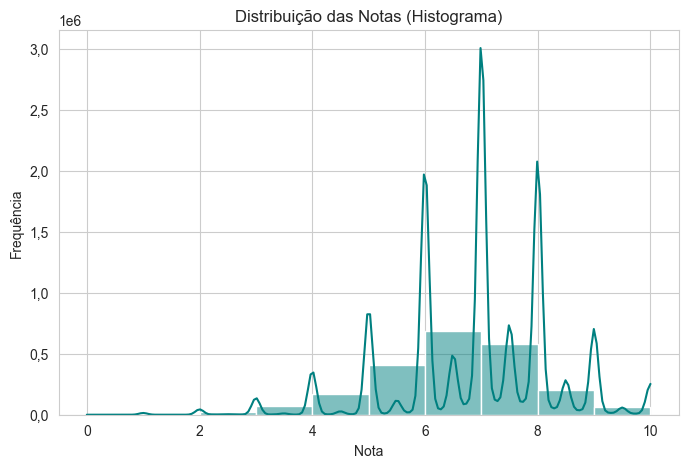

In [152]:
# Configuração visual
sns.set_style("whitegrid")

# --- 1. Estatísticas Descritivas das Notas ---
print("--- Estatísticas Descritivas das Notas ---")
all_ratings = ratings['Rating']
print(f"Média: {all_ratings.mean():.4f}")
print(f"Mediana: {all_ratings.median():.4f}")
print(f"Assimetria (Skewness): {skew(all_ratings):.4f}")
print(f"Curtose (Kurtosis): {kurtosis(all_ratings):.4f}")

# Gráfico 1: Histograma de Notas
plt.figure(figsize=(8, 5))
sns.histplot(all_ratings, bins=10, kde=True, color='teal')
plt.title('Distribuição das Notas (Histograma)')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.savefig('images\hist_notas.png') # Salva para usar no Latex
plt.show()


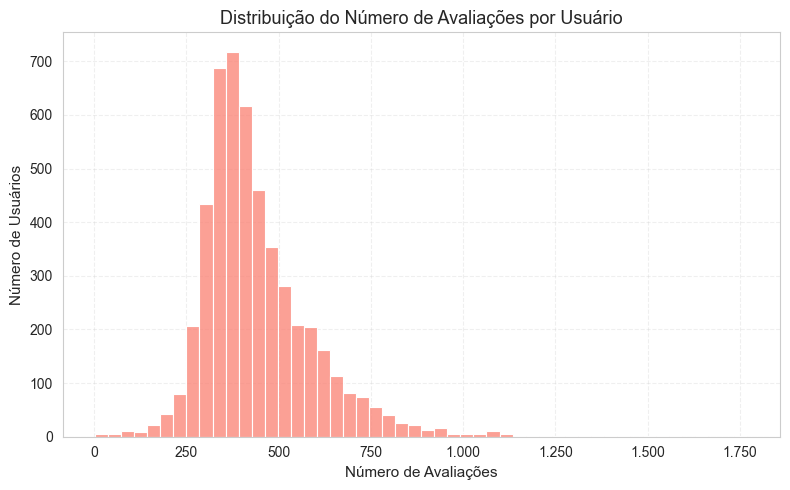

In [65]:
# --- 2. Distribuições de Cauda Longa ---
# Avaliações por Usuário
user_counts = ratings['Username'].value_counts()
# Avaliações por Jogo
game_counts = ratings['BGGId'].value_counts()

# ============================================================
# Distribuição do Número de Avaliações por Usuário
# ============================================================

plt.figure(figsize=(8, 5))

sns.histplot(
    user_counts,
    bins=50,
    color='salmon'
)

plt.title('Distribuição do Número de Avaliações por Usuário', fontsize=13)
plt.xlabel('Número de Avaliações', fontsize=11)
plt.ylabel('Número de Usuários', fontsize=11)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('images/dist_avaliacoes_usuario.png', dpi=300)
plt.show()



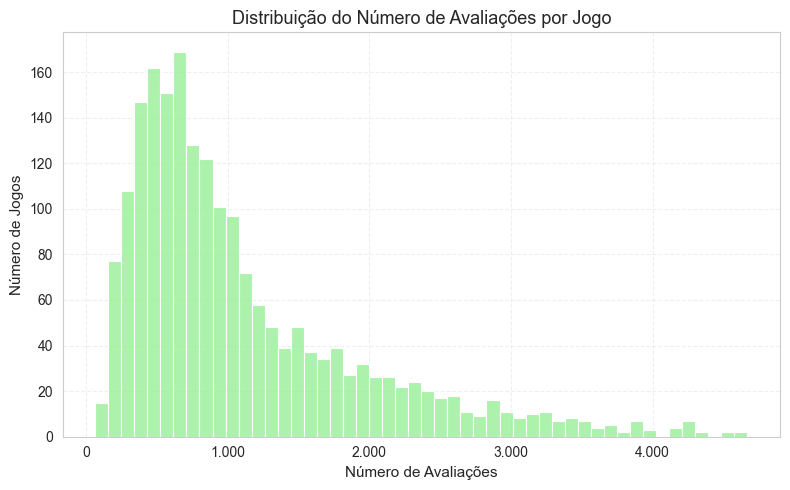

In [66]:
# ============================================================
# Distribuição do Número de Avaliações por Jogo
# ============================================================

plt.figure(figsize=(8, 5))

sns.histplot(
    game_counts,
    bins=50,
    color='lightgreen'
)

plt.title('Distribuição do Número de Avaliações por Jogo', fontsize=13)
plt.xlabel('Número de Avaliações', fontsize=11)
plt.ylabel('Número de Jogos', fontsize=11)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('images/dist_avaliacoes_jogo.png', dpi=300)
plt.show()



Correlação (Pearson):  0,2781
Correlação (Spearman): 0,2501


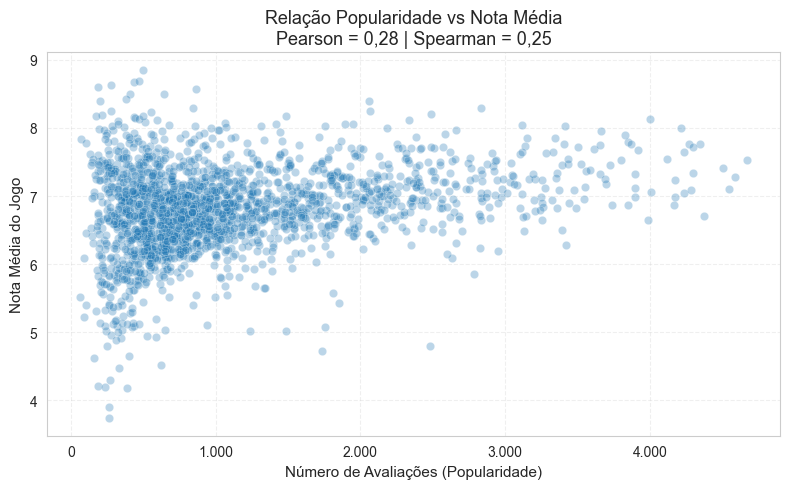

In [70]:

# --- 3. Correlação Popularidade vs Nota ---
game_stats = ratings.groupby('BGGId')['Rating'].agg(['count', 'mean'])
correlation = game_stats.corr(method='pearson') # Pode mudar para 'spearman'

game_stats = ratings.groupby('BGGId')['Rating'].agg(['count', 'mean'])

# Correlações
pearson_corr = game_stats['count'].corr(game_stats['mean'], method='pearson')
spearman_corr = game_stats['count'].corr(game_stats['mean'], method='spearman')

print(f"\nCorrelação (Pearson):  {pearson_corr:.4f}".replace('.', ','))
print(f"Correlação (Spearman): {spearman_corr:.4f}".replace('.', ','))

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=game_stats,
    x='count',
    y='mean',
    alpha=0.3
)

# Título com vírgula decimal
title = (
    f'Relação Popularidade vs Nota Média\n'
    f'Pearson = {pearson_corr:.2f} | Spearman = {spearman_corr:.2f}'
).replace('.', ',')

plt.title(title, fontsize=13)
plt.xlabel('Número de Avaliações (Popularidade)', fontsize=11)
plt.ylabel('Nota Média do Jogo', fontsize=11)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('images/scatter_pop_nota.png', dpi=300)
plt.show()



Correlação (Spearman): 0.2501
Correlação (Pearson):  0.2781


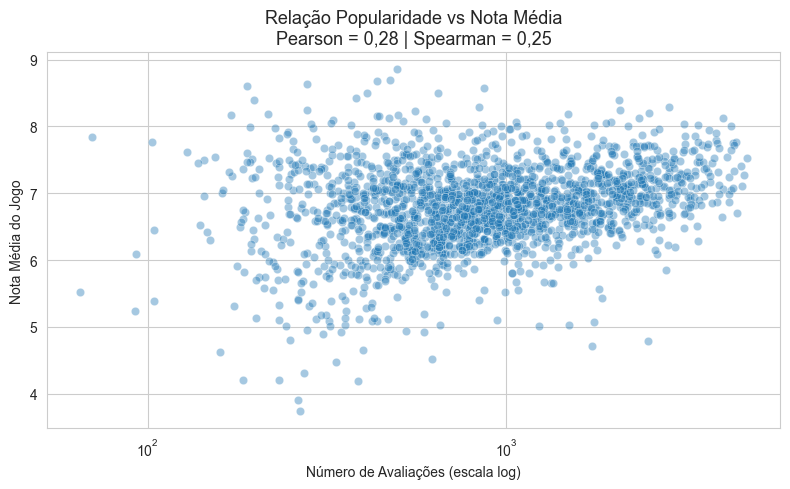

In [72]:

import seaborn as sns
import matplotlib.pyplot as plt

# --- 3. Correlação Popularidade vs Nota ---

game_stats = (
    ratings
    .groupby('BGGId')['Rating']
    .agg(['count', 'mean'])
)

# Filtra jogos com poucas avaliações (opcional, mas recomendado)
game_stats = game_stats[game_stats['count'] >= 5]

# Correlação de Spearman (mais adequada)
spearman_corr = game_stats.corr(method='spearman').loc['count', 'mean']
pearson_corr  = game_stats.corr(method='pearson').loc['count', 'mean']

print(f"Correlação (Spearman): {spearman_corr:.4f}")
print(f"Correlação (Pearson):  {pearson_corr:.4f}")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=game_stats,
    x='count',
    y='mean',
    alpha=0.4
)

plt.xscale('log')
plt.xlabel('Número de Avaliações (escala log)')
plt.ylabel('Nota Média do Jogo')

title = (
    f'Relação Popularidade vs Nota Média\n'
    f'Pearson = {pearson_corr:.2f} | Spearman = {spearman_corr:.2f}'
).replace('.', ',')

plt.title(title, fontsize=13)

plt.tight_layout()
plt.savefig('images/scatter_pop_nota_log.png')
plt.show()



### 5. Divisão Treino/Teste por Usuário

A função `split_user` realiza a divisão dos dados mantendo **separação por usuário**, evitando que dados do mesmo usuário apareçam tanto no treino quanto no teste.

**Filtro de mínimo de 5 avaliações:**
- Usuários com **≤ 5 avaliações** são excluídos do conjunto de teste
- Motivo: ao dividir 20% dos dados, usuários com poucas avaliações (ex: 2-3) resultariam em 0-1 avaliação no teste, insuficiente para avaliação
- Usuários com **> 5 avaliações** garantem pelo menos 1 avaliação no teste e histórico suficiente no treino

Esta abordagem é adequada para sistemas de recomendação, onde é essencial que o modelo aprenda padrões de cada usuário antes de predizer suas avaliações.

In [6]:
# --- Divisão treino/teste por usuário ---
def split_user(df, test_size=0.2):
    test_rows = []
    for user, group in df.groupby('Username'):
        if len(group) > 5:
            test = group.sample(frac=test_size, random_state=42)
            test_rows.append(test)
    test_df = pd.concat(test_rows)
    train_df = df.drop(test_df.index)
    return train_df, test_df

train_df, test_df = split_user(ratings)


## **Filtragem Colaborativa: User-User**

### 1. Matriz Usuário-Item

In [7]:
# --- Criar matriz usuário-item ---
R_train = train_df.pivot(index='Username', columns='BGGId', values='Rating')
R_test = test_df.pivot(index='Username', columns='BGGId', values='Rating')
R_test = R_test.reindex_like(R_train)

### 2. Similaridade Pearson


In [8]:
# 1. Pearson (sim_cf_pearson)
# O método .corr() do pandas nas linhas (que são os usuários) calcula a correlação entre usuários,
# considerando apenas os itens co-avaliados.
sim_cf_pearson = R_train.T.corr(method='pearson')
sim_cf_pearson = pd.DataFrame(sim_cf_pearson, index=R_train.index, columns=R_train.index)
print("1. CF (Pearson User-User) Similaridade Calculada.")

1. CF (Pearson User-User) Similaridade Calculada.


### 3. Funções Úteis

#### 3.1 Função de Predição

In [9]:
# ============================================================================
# FUNÇÃO FC CORRIGIDA
# ============================================================================

def predict_cf_user_user_corrected(user_id, item_id, R_train, sim_matrix, user_means, k=30):
    """
    Prevê a nota usando CF User-User (CORRIGIDA).
    Seleciona top-k por |sim(u,v)|, não por |sim × desvio|.
    
    Fórmula (2.2): r̂_u,i = r̄_u + Σ(sim(u,v) × (r_v,i - r̄_v)) / Σ|sim(u,v)|
    """
    
    # 1. Fallback
    if user_id not in user_means.index or item_id not in R_train.columns:
        return user_means.get(user_id, 0.0)
    
    # 2. Média do usuário
    mean_u = user_means[user_id]
    
    # 3. Usuários que avaliaram o item
    rated_by_v = R_train[item_id].dropna().index
    sim_u_v = sim_matrix.loc[user_id, rated_by_v].drop(user_id, errors='ignore')
    
    if sim_u_v.empty:
        return mean_u
    
    # 4. CORREÇÃO: Selecionar top-k por |sim(u,v)|
    top_k_neighbors = sim_u_v.abs().nlargest(k).index  # ✅ CORRETO
    
    # 5. Componentes do somatório
    sim_k = sim_u_v.loc[top_k_neighbors]
    ratings_k = R_train.loc[top_k_neighbors, item_id]
    means_k = user_means.loc[top_k_neighbors]
    
    # 6. Equação (2.2)
    denominator = sim_k.abs().sum()
    
    if denominator == 0:
        return mean_u
    
    numerator = (sim_k * (ratings_k - means_k)).sum()
    prediction = mean_u + (numerator / denominator)
    
    return prediction

#### 3.2 Métricas de Acurácia

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_accuracy_metrics(y_true, y_pred):
    """Calcula RMSE e MAE."""
    # Remove pares onde não foi possível fazer a previsão (se houver NaNs nas previsões)
    valid_indices = ~np.isnan(y_pred)
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    
    if len(y_true_valid) == 0:
        return np.nan, np.nan
        
    rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    mae = mean_absolute_error(y_true_valid, y_pred_valid)
    return rmse, mae



#### 3.3 Métricas de Rankeamento

In [11]:
def calculate_ranking_metrics(R_train, R_test, predictions_df, relevance_threshold=7.0, N=10):
    """Calcula Precision@N e Recall@N."""
    
    all_precision = []
    all_recall = []
    
    # Itera sobre cada usuário no conjunto de teste
    for user in R_test.index:
        # Pega as avaliações reais e previstas do usuário no conjunto de teste
        true_ratings = R_test.loc[user].dropna()
        if true_ratings.empty:
            continue
            
        # 1. Itens realmente relevantes (True Positives + False Negatives)
        relevant_items = true_ratings[true_ratings >= relevance_threshold].index
        
        # 2. Previsões para todos os itens não avaliados no treino
        # Encontra itens que o usuário não avaliou no treino, mas que existem na base
        unrated_items = R_train.columns.difference(R_train.loc[user].dropna().index)
        
        # Usa as previsões que você gerou, mas também precisamos prever para itens
        # que o usuário *não* avaliou no treino (mas que avaliou no teste)
        
        # Para simplificar, vamos usar as previsões geradas APENAS para os itens do TESTE.
        # Em um cenário real, você faria previsões para todos os itens não avaliados.
        
        # Pega as previsões para os itens que o usuário avaliou no teste
        user_predictions = predictions_df.loc[user, true_ratings.index].dropna()
        
        if user_predictions.empty:
            continue
            
        # 3. Ranqueia e seleciona o Top N
        top_n_recommended = user_predictions.sort_values(ascending=False).head(N).index
        
        # 4. Cálculo da Métrica
        # Intersecção: itens recomendados que são relevantes (True Positives)
        hits = len(top_n_recommended.intersection(relevant_items))
        
        # Precision@N: TP / (TP + FP) = Hits / N
        precision = hits / N
        all_precision.append(precision)
        
        # Recall@N: TP / (TP + FN) = Hits / Total de relevantes
        if len(relevant_items) > 0:
            recall = hits / len(relevant_items)
            all_recall.append(recall)
        
    avg_precision = np.mean(all_precision)
    avg_recall = np.mean(all_recall)
    return avg_precision, avg_recall

### 5. Ajustando o Modelo

#### 5.1 Configuração

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

print("="*80)
print("ANÁLISE COMPLETA FC USER-USER - FILTRAGEM COLABORATIVA")
print("="*80)

# ============================================================================
# 1. CONFIGURAÇÃO
# ============================================================================

k_values_fc = [10, 20, 30, 40, 50, 60, 80, 100]
N_RANKING_FC = 10
RELEVANCE_THRESHOLD_FC = 7.0

print(f"\nValores de k a testar: {k_values_fc}")
print(f"Métricas de Ranking: Precision@{N_RANKING_FC} e Recall@{N_RANKING_FC}")
print(f"Threshold de relevância: {RELEVANCE_THRESHOLD_FC}")

ANÁLISE COMPLETA FC USER-USER - FILTRAGEM COLABORATIVA

Valores de k a testar: [10, 20, 30, 40, 50, 60, 80, 100]
Métricas de Ranking: Precision@10 e Recall@10
Threshold de relevância: 7.0


#### 5.2 Pré Processamento

In [13]:
# ============================================================================
# 2. PRÉ-PROCESSAMENTO
# ============================================================================

print("\nPré-processando dados...")

start_prep = time.time()

user_means = R_train.mean(axis=1)
user_means_dict_fc = user_means.to_dict()

sim_matrix_fc = sim_cf_pearson  # Usar a matriz Pearson

print(f"Pré-processamento concluído em {time.time() - start_prep:.1f}s")


Pré-processando dados...
Pré-processamento concluído em 0.1s


#### 5.3 Predições para vários valores de K

In [14]:
# ============================================================================
# 3. CÁLCULO DAS PREDIÇÕES PARA TODOS OS K
# ============================================================================

print(f"\nCalculando predições para {len(test_df)} linhas...")

preds_per_k_fc = {k: [] for k in k_values_fc}
y_true_fc = []

total_rows = len(test_df)
start_time = time.time()

for idx, row in enumerate(test_df.itertuples(index=False)):
    user = row.Username
    item = row.BGGId
    y_true_fc.append(row.Rating)
    
    # Progress bar
    if idx % 10000 == 0 and idx > 0:
        elapsed = time.time() - start_time
        rate = idx / elapsed
        eta = (total_rows - idx) / rate
        print(f"  Progresso: {idx}/{total_rows} ({idx/total_rows*100:.1f}%) - "
              f"{rate:.0f} linhas/s - ETA: {eta:.0f}s")
    
    # Fallback
    if user not in user_means.index or item not in R_train.columns:
        default_val = user_means_dict_fc.get(user, 0.0)
        for k in k_values_fc:
            preds_per_k_fc[k].append(default_val)
        continue
    
    mean_u = user_means_dict_fc[user]
    
    # Usuários que avaliaram o item
    rated_by_v = R_train[item].dropna().index
    sim_u_v = sim_matrix_fc.loc[user, rated_by_v].drop(user, errors='ignore')
    
    if len(sim_u_v) == 0:
        for k in k_values_fc:
            preds_per_k_fc[k].append(mean_u)
        continue
    
    # Ordenar por |sim(u,v)| UMA VEZ
    sorted_neighbors = sim_u_v.abs().sort_values(ascending=False).index
    
    # Calcular para cada k
    for k in k_values_fc:
        k_actual = min(k, len(sorted_neighbors))
        top_k_neighbors = sorted_neighbors[:k_actual]
        
        sim_k = sim_u_v.loc[top_k_neighbors]
        ratings_k = R_train.loc[top_k_neighbors, item]
        means_k = user_means.loc[top_k_neighbors]
        
        denominator = sim_k.abs().sum()
        
        if denominator == 0:
            preds_per_k_fc[k].append(mean_u)
        else:
            numerator = (sim_k * (ratings_k - means_k)).sum()
            prediction = mean_u + (numerator / denominator)
            preds_per_k_fc[k].append(prediction)

elapsed = time.time() - start_time
print(f"\n✅ Predições concluídas em {elapsed:.2f}s ({total_rows/elapsed:.0f} linhas/s)")

# Converter y_true para array
y_true_fc = np.array(y_true_fc)


Calculando predições para 443561 linhas...
  Progresso: 10000/443561 (2.3%) - 297 linhas/s - ETA: 1461s
  Progresso: 20000/443561 (4.5%) - 292 linhas/s - ETA: 1452s
  Progresso: 30000/443561 (6.8%) - 294 linhas/s - ETA: 1405s
  Progresso: 40000/443561 (9.0%) - 296 linhas/s - ETA: 1365s
  Progresso: 50000/443561 (11.3%) - 297 linhas/s - ETA: 1327s
  Progresso: 60000/443561 (13.5%) - 297 linhas/s - ETA: 1290s
  Progresso: 70000/443561 (15.8%) - 297 linhas/s - ETA: 1256s
  Progresso: 80000/443561 (18.0%) - 298 linhas/s - ETA: 1222s
  Progresso: 90000/443561 (20.3%) - 298 linhas/s - ETA: 1188s
  Progresso: 100000/443561 (22.5%) - 297 linhas/s - ETA: 1156s
  Progresso: 110000/443561 (24.8%) - 298 linhas/s - ETA: 1121s
  Progresso: 120000/443561 (27.1%) - 298 linhas/s - ETA: 1086s
  Progresso: 130000/443561 (29.3%) - 298 linhas/s - ETA: 1052s
  Progresso: 140000/443561 (31.6%) - 298 linhas/s - ETA: 1018s
  Progresso: 150000/443561 (33.8%) - 298 linhas/s - ETA: 985s
  Progresso: 160000/44356

#### 5.4 Cálculo das Métricas de Acurácia

In [15]:
# ============================================================================
# 4. MÉTRICAS DE ACURÁCIA
# ============================================================================

print("\n" + "="*80)
print("MÉTRICAS DE ACURÁCIA (FC)")
print("="*80)

rmse_results_fc = []
mae_results_fc = []

for k in k_values_fc:
    y_pred = np.array(preds_per_k_fc[k])
    
    n_nan = np.isnan(y_pred).sum()
    if n_nan > 0:
        print(f"⚠️ k={k}: {n_nan} predições são NaN")
    
    rmse, mae = calculate_accuracy_metrics(y_true_fc, y_pred)
    rmse_results_fc.append(rmse)
    mae_results_fc.append(mae)
    print(f"k={k:3d} -> RMSE: {rmse:.4f} | MAE: {mae:.4f}")




MÉTRICAS DE ACURÁCIA (FC)
k= 10 -> RMSE: 1.1225 | MAE: 0.8451
k= 20 -> RMSE: 1.1024 | MAE: 0.8275
k= 30 -> RMSE: 1.0959 | MAE: 0.8220
k= 40 -> RMSE: 1.0931 | MAE: 0.8195
k= 50 -> RMSE: 1.0916 | MAE: 0.8181
k= 60 -> RMSE: 1.0907 | MAE: 0.8173
k= 80 -> RMSE: 1.0898 | MAE: 0.8163
k=100 -> RMSE: 1.0895 | MAE: 0.8159


#### 5.5. Cálculo das Métricas de Ranking

In [16]:
# ============================================================================
# 5. MÉTRICAS DE RANKING
# ============================================================================

print("\n" + "="*80)
print("MÉTRICAS DE RANKING (FC)")
print("="*80)

precision_results_fc = []
recall_results_fc = []

for k in k_values_fc:
    print(f"Calculando P@{N_RANKING_FC} e R@{N_RANKING_FC} para k={k}...")
    
    predictions_dict = {}
    for idx, row in enumerate(test_df.itertuples(index=False)):
        predictions_dict[(row.Username, row.BGGId)] = preds_per_k_fc[k][idx]
    
    pred_series = pd.Series(
        predictions_dict,
        index=pd.MultiIndex.from_tuples(predictions_dict.keys(), names=['Username', 'BGGId'])
    )
    
    predictions_df = pred_series.unstack()
    
    precision, recall = calculate_ranking_metrics(
        R_train, R_test, predictions_df,
        relevance_threshold=RELEVANCE_THRESHOLD_FC,
        N=N_RANKING_FC
    )
    
    precision_results_fc.append(precision)
    recall_results_fc.append(recall)
    print(f"  k={k:3d} -> P@{N_RANKING_FC}: {precision:.4f} | R@{N_RANKING_FC}: {recall:.4f}")




MÉTRICAS DE RANKING (FC)
Calculando P@10 e R@10 para k=10...
  k= 10 -> P@10: 0.8509 | R@10: 0.1727
Calculando P@10 e R@10 para k=20...
  k= 20 -> P@10: 0.8631 | R@10: 0.1762
Calculando P@10 e R@10 para k=30...
  k= 30 -> P@10: 0.8662 | R@10: 0.1769
Calculando P@10 e R@10 para k=40...
  k= 40 -> P@10: 0.8682 | R@10: 0.1775
Calculando P@10 e R@10 para k=50...
  k= 50 -> P@10: 0.8700 | R@10: 0.1780
Calculando P@10 e R@10 para k=60...
  k= 60 -> P@10: 0.8699 | R@10: 0.1779
Calculando P@10 e R@10 para k=80...
  k= 80 -> P@10: 0.8706 | R@10: 0.1781
Calculando P@10 e R@10 para k=100...
  k=100 -> P@10: 0.8709 | R@10: 0.1781


#### 5.6 Resumo e Identificação do Melhor K (tabelas)

In [17]:
# ============================================================================
# 6. RESUMO E IDENTIFICAÇÃO DO MELHOR K
# ============================================================================

print("\n" + "="*80)
print("RESUMO COMPLETO (FC)")
print("="*80)
print(f"{'k':<5} {'RMSE':<10} {'MAE':<10} {'Precision@10':<15} {'Recall@10':<10}")
print("-"*60)
for i, k in enumerate(k_values_fc):
    print(f"{k:<5} {rmse_results_fc[i]:<10.4f} {mae_results_fc[i]:<10.4f} "
          f"{precision_results_fc[i]:<15.4f} {recall_results_fc[i]:<10.4f}")

# Identificar melhor k
best_rmse_idx_fc = np.argmin(rmse_results_fc)
best_mae_idx_fc = np.argmin(mae_results_fc)
best_precision_idx_fc = np.argmax(precision_results_fc)
best_recall_idx_fc = np.argmax(recall_results_fc)

print("\n" + "="*80)
print("MELHOR K POR MÉTRICA (FC)")
print("="*80)
print(f"Melhor RMSE:      k={k_values_fc[best_rmse_idx_fc]} (RMSE={rmse_results_fc[best_rmse_idx_fc]:.4f})")
print(f"Melhor MAE:       k={k_values_fc[best_mae_idx_fc]} (MAE={mae_results_fc[best_mae_idx_fc]:.4f})")
print(f"Melhor Precision: k={k_values_fc[best_precision_idx_fc]} (P@10={precision_results_fc[best_precision_idx_fc]:.4f})")
print(f"Melhor Recall:    k={k_values_fc[best_recall_idx_fc]} (R@10={recall_results_fc[best_recall_idx_fc]:.4f})")




RESUMO COMPLETO (FC)
k     RMSE       MAE        Precision@10    Recall@10 
------------------------------------------------------------
10    1.1225     0.8451     0.8509          0.1727    
20    1.1024     0.8275     0.8631          0.1762    
30    1.0959     0.8220     0.8662          0.1769    
40    1.0931     0.8195     0.8682          0.1775    
50    1.0916     0.8181     0.8700          0.1780    
60    1.0907     0.8173     0.8699          0.1779    
80    1.0898     0.8163     0.8706          0.1781    
100   1.0895     0.8159     0.8709          0.1781    

MELHOR K POR MÉTRICA (FC)
Melhor RMSE:      k=100 (RMSE=1.0895)
Melhor MAE:       k=100 (MAE=0.8159)
Melhor Precision: k=100 (P@10=0.8709)
Melhor Recall:    k=100 (R@10=0.1781)


In [18]:
# ============================================================================
# 7. ESCOLHER MELHOR K (você pode mudar depois)
# ============================================================================

# Por padrão, escolher o k com melhor RMSE
best_k_fc = 50
print(f"\n🎯 K ESCOLHIDO PARA FC: {best_k_fc} (baseado no menor RMSE)")

# Criar dicionário de predições para o melhor k
predictions_dict_fc = {}
for idx, row in enumerate(test_df.itertuples(index=False)):
    predictions_dict_fc[(row.Username, row.BGGId)] = preds_per_k_fc[best_k_fc][idx]

# Criar Series com MultiIndex
pred_series_fc = pd.Series(
    predictions_dict_fc,
    index=pd.MultiIndex.from_tuples(predictions_dict_fc.keys(), names=['Username', 'BGGId'])
)

# Alinhar com test_df (igual ao código original)
y_pred_fc = pred_series_fc.reindex(test_df.set_index(['Username', 'BGGId']).index).values

# Métricas do melhor k
rmse_fc = rmse_results_fc[best_rmse_idx_fc]
mae_fc = mae_results_fc[best_rmse_idx_fc]
precision_fc = precision_results_fc[best_rmse_idx_fc]
recall_fc = recall_results_fc[best_rmse_idx_fc]

results_fc = {
    'k': best_k_fc,
    'RMSE': rmse_fc,
    'MAE': mae_fc,
    'Precision@10': precision_fc,
    'Recall@10': recall_fc
}

print(f"\nResultados FC (k={best_k_fc}):")
for key, value in results_fc.items():
    if key == 'k':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.4f}")

# Verificar alinhamento
print(f"\nVerificação de alinhamento:")
print(f"  y_true_fc shape: {y_true_fc.shape}")
print(f"  y_pred_fc shape: {y_pred_fc.shape}")
print(f"  NaNs em y_pred_fc: {np.isnan(y_pred_fc).sum()}")




🎯 K ESCOLHIDO PARA FC: 50 (baseado no menor RMSE)

Resultados FC (k=50):
  k: 50
  RMSE: 1.0895
  MAE: 0.8159
  Precision@10: 0.8709
  Recall@10: 0.1781

Verificação de alinhamento:
  y_true_fc shape: (443561,)
  y_pred_fc shape: (443561,)
  NaNs em y_pred_fc: 0


#### 5.7 Gráficos


Gerando gráficos...


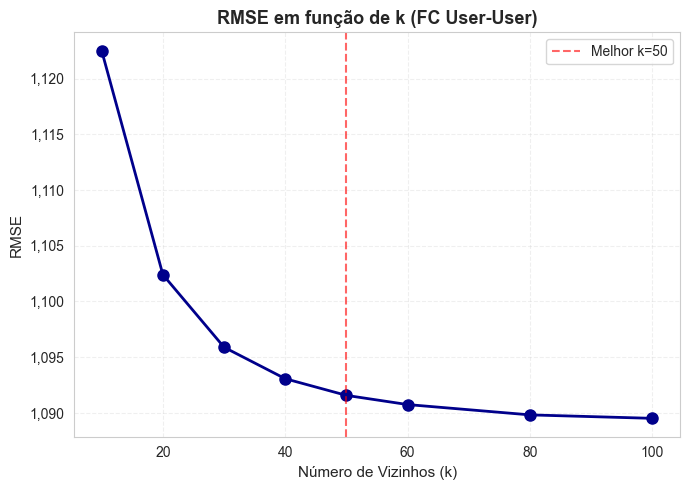

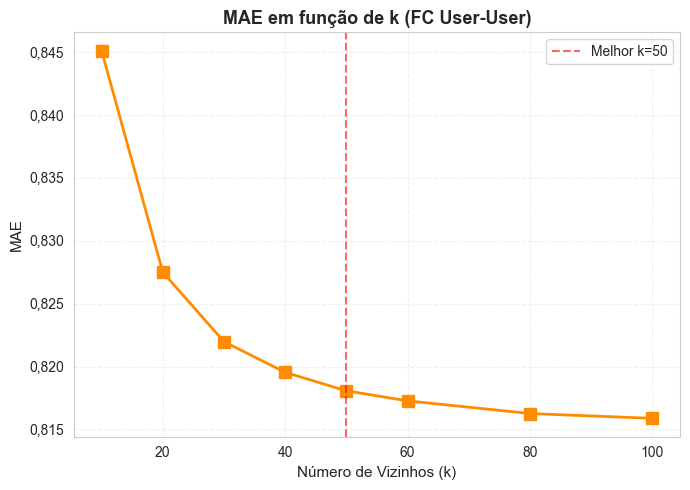

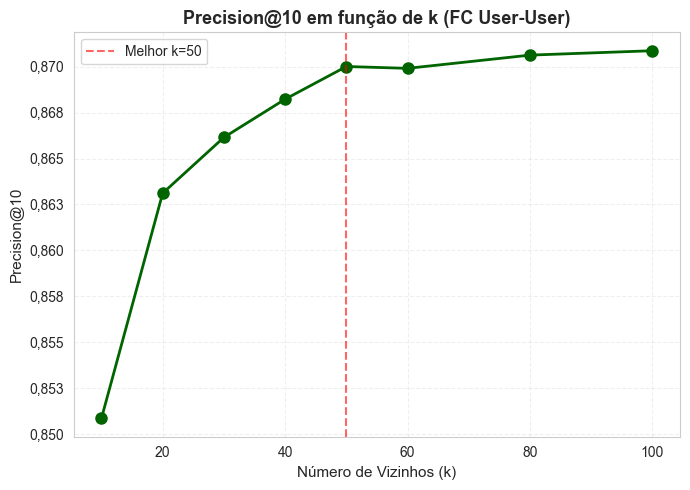

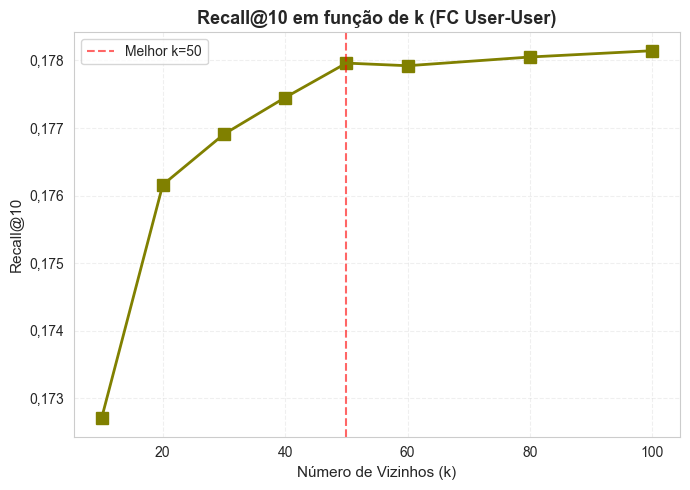


✅ ANÁLISE FC USER-USER COMPLETA!

Variáveis disponíveis para comparação:
  - best_k_fc = 50
  - y_true_fc: array com 443561 valores reais
  - y_pred_fc: array com 443561 predições (k=50)
  - pred_series_fc: Series com MultiIndex
  - preds_per_k_fc: dict com predições para cada k
  - rmse_fc = 1.0895
  - mae_fc = 0.8159
  - precision_fc = 0.8709
  - recall_fc = 0.1781
  - results_fc: dict com todas as métricas


In [81]:
# ============================================================================
# 8. GRÁFICOS
# ============================================================================

print("\nGerando gráficos...")

# ----------------------------------------------------------------
# GRÁFICO 1: MÉTRICAS DE ACURÁCIA (RMSE e MAE) — LADO A LADO
# ----------------------------------------------------------------

# RMSE
plt.figure(figsize=(7, 5))
plt.plot(
    k_values_fc, rmse_results_fc,
    marker='o', linewidth=2, markersize=8, color='darkblue'
)

plt.axvline(x=best_k_fc, color='red', linestyle='--', alpha=0.6,
            label=f'Melhor k={best_k_fc}')

plt.title('RMSE em função de k (FC User-User)', fontsize=13, fontweight='bold')
plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('RMSE', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/fc_k_rmse.png', dpi=300, bbox_inches='tight')
plt.show()


# MAE
plt.figure(figsize=(7, 5))
plt.plot(
    k_values_fc, mae_results_fc,
    marker='s', linewidth=2, markersize=8, color='darkorange'
)

plt.axvline(x=best_k_fc, color='red', linestyle='--', alpha=0.6,
            label=f'Melhor k={best_k_fc}')

plt.title('MAE em função de k (FC User-User)', fontsize=13, fontweight='bold')
plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('MAE', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/fc_k_mae.png', dpi=300, bbox_inches='tight')
plt.show()


# ----------------------------------------------------------------
# GRÁFICO 2: MÉTRICAS DE RANKING (Precision@10 e Recall@10) — LADO A LADO
# ----------------------------------------------------------------

# Precision@10
plt.figure(figsize=(7, 5))
plt.plot(
    k_values_fc, precision_results_fc,
    marker='o', linewidth=2, markersize=8, color='darkgreen'
)

plt.axvline(x=best_k_fc, color='red', linestyle='--', alpha=0.6,
            label=f'Melhor k={best_k_fc}')

plt.title('Precision@10 em função de k (FC User-User)', fontsize=13, fontweight='bold')
plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('Precision@10', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/fc_k_precision.png', dpi=300, bbox_inches='tight')
plt.show()


# Recall@10
plt.figure(figsize=(7, 5))
plt.plot(
    k_values_fc, recall_results_fc,
    marker='s', linewidth=2, markersize=8, color='olive'
)

plt.axvline(x=best_k_fc, color='red', linestyle='--', alpha=0.6,
            label=f'Melhor k={best_k_fc}')

plt.title('Recall@10 em função de k (FC User-User)', fontsize=13, fontweight='bold')
plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('Recall@10', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/fc_k_recall.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*80)
print("✅ ANÁLISE FC USER-USER COMPLETA!")
print("="*80)
print("\nVariáveis disponíveis para comparação:")
print(f"  - best_k_fc = {best_k_fc}")
print(f"  - y_true_fc: array com {len(y_true_fc)} valores reais")
print(f"  - y_pred_fc: array com {len(y_pred_fc)} predições (k={best_k_fc})")
print(f"  - pred_series_fc: Series com MultiIndex")
print(f"  - preds_per_k_fc: dict com predições para cada k")
print(f"  - rmse_fc = {rmse_fc:.4f}")
print(f"  - mae_fc = {mae_fc:.4f}")
print(f"  - precision_fc = {precision_fc:.4f}")
print(f"  - recall_fc = {recall_fc:.4f}")
print(f"  - results_fc: dict com todas as métricas")

## **Método Baseline**

### 1. Explicações



O método **Baseline** (ou Média Ajustada) é uma abordagem fundamental e um ponto de partida em sistemas de recomendação. Ele é um modelo preditivo que tenta explicar a variação das avaliações dos usuários com base em **três componentes principais de viés**.

A principal característica do modelo Baseline é sua **simplicidade** e **interpretabilidade**, pois ele não depende da similaridade entre usuários ou itens, mas sim de tendências médias.

#### 📝 Fórmula e Componentes

A previsão da nota ($\hat{r}_{u,i}$) que o usuário $u$ daria ao item $i$ é dada pela soma de três fatores de viés:

$$\hat{r}_{u,i} = \mu + b_u + b_i$$

Onde:

##### 1. Média Global ($\mu$)

* **Definição:** A média de **todas** as avaliações presentes no conjunto de treino.
* **Interpretação:** É o valor médio esperado para qualquer avaliação, sem saber nada sobre o usuário ou o item.

##### 2. Viés do Usuário ($b_u$)

* **Definição:** O desvio médio do usuário $u$ em relação à média global $\mu$.
* **Cálculo:** $b_u = (\text{Média das notas de } u) - \mu$
* **Interpretação:**
    * Se $b_u > 0$, o usuário $u$ tende a dar notas **mais altas** que a média geral (um avaliador "bonzinho").
    * Se $b_u < 0$, o usuário $u$ tende a dar notas **mais baixas** que a média geral (um avaliador "rigoroso").

##### 3. Viés do Item ($b_i$)

* **Definição:** O desvio médio do item $i$ em relação à média global $\mu$.
* **Cálculo:** $b_i = (\text{Média das notas de } i) - \mu$
* **Interpretação:**
    * Se $b_i > 0$, o item $i$ tende a receber notas **mais altas** que a média (um item popular/bom).
    * Se $b_i < 0$, o item $i$ tende a receber notas **mais baixas** que a média (um item impopular/ruim).

#### 💡 Funcionamento e Aplicação

O modelo funciona somando esses vieses à média global. Por exemplo:

> Se a Média Global ($\mu$) é **7.5**, e o usuário $u$ tende a dar notas 0.5 ponto **acima** da média ($b_u = +0.5$), e o item $i$ é 0.2 ponto **abaixo** da média ($b_i = -0.2$), a previsão será:
>
> $$\hat{r}_{u,i} = 7.5 + 0.5 + (-0.2) = 7.8$$

#### Vantagens do Método Baseline

* **Simplicidade e Rapidez:** Extremamente rápido de treinar e de fazer previsões.
* **Referência:** Serve como um **piso de desempenho (benchmark)**. Qualquer modelo mais complexo (como CF ou Fatoração de Matriz) deve superar o Baseline para ser considerado útil.
* **Base para Fatoração de Matriz:** Muitos modelos avançados, como SVD e FunkSVD, utilizam o modelo Baseline como a primeira camada de suas previsões, adicionando fatores latentes (componentes não-viesados) sobre a fórmula $\mu + b_u + b_i$.

### 2. Média Global, Viés de Usuário e Viés de Item

In [104]:
#R_train_na = R_train.fillna(0)

# 1. Média Global (mu)
mu = np.nanmean(R_train.values)

# 2. Viés do Item (bi)
#bi = train_df.groupby('BGGId')['Rating'].mean() - mu
bi = R_train.apply(lambda col: np.nanmean(col - mu), axis=0)

# 3. Viés do Usuário (bu)
#bu = train_df.groupby('Username')['Rating'].mean() - mu #- bi
bu = R_train.apply(lambda row: np.nanmean(row - mu - bi), axis=1)


print(f"Média Global (mu): {mu:.4f}")
#print(f"\nVieses (bi) calculados para {len(bi)} itens: \n{bi.head()}.")
#print(f"\nVieses (bu) calculados para {len(bu)} usuários: \n{bu.head()}.")


Média Global (mu): 6.9319


### 3. Exemplo de aplicação

In [21]:
import pandas as pd
import numpy as np

# --- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---
print("--- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---")
print("------------------------------------------------------------------")

# 1. Selecionar 5 usuários únicos e aleatórios do conjunto de teste
try:
    unique_users = test_df['Username'].unique()
    
    if len(unique_users) < 5:
        # Se houver menos de 5 usuários únicos, usamos todos
        users_to_sample = unique_users
        print(f"Atenção: A base de teste tem apenas {len(unique_users)} usuários únicos. Exibindo todos.")
    else:
        # Escolhe 5 usuários aleatórios únicos (replace=False)
        users_to_sample = np.random.choice(unique_users, size=5, replace=False)

except Exception as e:
    # Este erro não deve ocorrer se 'test_df' estiver definido
    print(f"Erro ao selecionar usuários únicos (Variáveis não definidas?): {e}")
    users_to_sample = []

i = 0
# 2. Iterar sobre os 5 usuários selecionados e pegar 1 item de teste para cada
for user_id in users_to_sample:
    # Pega o primeiro item avaliado por este usuário no conjunto de teste
    # Usamos .iloc[0] para pegar o primeiro item deste usuário no test_df
    user_test_data = test_df[test_df['Username'] == user_id].iloc[0]
    
    item_id = user_test_data['BGGId']
    real_rating = user_test_data['Rating']

    try:
        # 3. Acessar os Vieses
        # Usamos .get() com 0.0 como fallback (embora os usuários e itens amostrados
        # estejam na base de treino e, portanto, em bu/bi)
        bu_val = bu.get(user_id, 0.0)
        bi_val = bi.get(item_id, 0.0)
        
        # 4. Previsão do Modelo Baseline
        pred_baseline = mu + bu_val + bi_val
        pred_baseline = np.clip(pred_baseline, 1.0, 10.0) # Limite de 1 a 10

        # 5. Cálculo do Erro
        erro_absoluto = abs(real_rating - pred_baseline)

        # 6. Apresentação dos resultados
        print(f"\n[Exemplo {i + 1}] User: {user_id}, Item: {item_id}")
        print(f"  > Viés User (bu): {bu_val:+.2f} | Viés Item (bi): {bi_val:+.2f} | Média Global (mu): {mu:.2f}")
        print(f"  > PREVISÃO BASELINE: {pred_baseline:.4f}")
        print(f"  > AVALIAÇÃO REAL:    {real_rating:.4f}")
        print(f"  > ERRO ABSOLUTO:     {erro_absoluto:.4f}")
        
    except Exception as e:
        print(f"\nErro ao processar o usuário {user_id}: {e}")
    
    i += 1

print("\n------------------------------------------------------------------")

--- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---
------------------------------------------------------------------

[Exemplo 1] User: buzzboke, Item: 193738
  > Viés User (bu): +0.21 | Viés Item (bi): +1.09 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 8.2341
  > AVALIAÇÃO REAL:    8.0000
  > ERRO ABSOLUTO:     0.2341

[Exemplo 2] User: bartok, Item: 62227
  > Viés User (bu): +0.52 | Viés Item (bi): +0.27 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 7.7270
  > AVALIAÇÃO REAL:    8.0000
  > ERRO ABSOLUTO:     0.2730

[Exemplo 3] User: eusebio_babilon, Item: 171879
  > Viés User (bu): +0.65 | Viés Item (bi): +0.13 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 7.7120
  > AVALIAÇÃO REAL:    7.8000
  > ERRO ABSOLUTO:     0.0880

[Exemplo 4] User: vandemonium, Item: 34585
  > Viés User (bu): +0.42 | Viés Item (bi): -0.52 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 6.8322
  > AVALIAÇÃO REAL:    7.0000
  > ERRO ABSOLUTO:     0.1678

[Exemplo 5] User: omopelo, It

### 4. Previsão do Baseline

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função de previsão usando o modelo baseline
def predict_baseline(user_id, item_id, mu, bu, bi):
    bu_i = bu.get(user_id, 0.0)
    bi_i = bi.get(item_id, 0.0)
    pred = mu + bu_i + bi_i
    return float(np.clip(pred, 1.0, 10.0))

# Prever todas as notas de teste
preds = {
    (u, i): predict_baseline(u, i, mu, bu, bi)
    for u, i in zip(test_df['Username'], test_df['BGGId'])
}
pred_series = pd.Series(preds, index=pd.MultiIndex.from_tuples(preds.keys(), names=['Username', 'BGGId']))
pred_bl_df = pred_series.unstack()

# Calcular métricas de erro
y_true = test_df['Rating'].values
y_pred_bl = pred_series.reindex(test_df.set_index(['Username', 'BGGId']).index).values


### 5. Métricas de Avaliação do Modelo Baseline

#### 4.1 Métricas de Acurácia: RMSE e MAE

In [106]:
rmse_bl = np.sqrt(mean_squared_error(y_true, y_pred_bl))
mae_bl = mean_absolute_error(y_true, y_pred_bl)
print(f"Baseline - RMSE: {rmse_bl:.4f}, MAE: {mae_bl:.4f}")

Baseline - RMSE: 1.1141, MAE: 0.8352


#### 4.2 Métricas de Rankeamento: Precisão e Recall

In [107]:
# 7. Calcular precisão@N e recall@N
R_test_matrix = test_df.pivot(index='Username', columns='BGGId', values='Rating').reindex_like(pred_bl_df)
precision_bl, recall_bl = calculate_ranking_metrics(R_train, R_test_matrix, pred_bl_df)

print(f"Baseline - Precision@10: {precision_bl:.4f}, Recall@10: {recall_bl:.4f}")

Baseline - Precision@10: 0.8488, Recall@10: 0.1721


## **Baseada em Conteúdo**

### 1. Matriz de Similaridade Jaccard

In [25]:
from scipy.spatial.distance import jaccard

# --- Funções Auxiliares (Jaccard) ---

def calculate_jaccard_similarity_matrix(df):
    """Calcula a matriz de Similaridade de Jaccard (1 - Distância Jaccard) para um DataFrame Item x Feature."""
    data_array = df.values
    n = data_array.shape[0]
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            # Jaccard é a distância (1 - Sim)
            dist = jaccard(data_array[i], data_array[j])
            sim = 1 - dist
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
            
    return pd.DataFrame(sim_matrix, index=df.index, columns=df.index)

# Preparação e Filtro da Matriz de Conteúdo (Item x Feature, alinhada aos itens de R_train)
# Assumimos que 'mechanics' foi preparado anteriormente, mas refazemos o alinhamento
mechanics_prepared = mechanics.set_index('BGGId').reindex(R_train.columns).fillna(0)

# 1. Calcular a Similaridade BC usando Jaccard (Item-Item)
sim_bc_jaccard = calculate_jaccard_similarity_matrix(mechanics_prepared)

print("Similaridade Baseada em Conteúdo (Jaccard) Item-Item Calculada.")
print(f"Dimensões da matriz sim_bc_jaccard: {sim_bc_jaccard.shape}")

Similaridade Baseada em Conteúdo (Jaccard) Item-Item Calculada.
Dimensões da matriz sim_bc_jaccard: (2000, 2000)


### 2. Funções Úteis

#### 2.1 Função de Predição

In [26]:
# ============================================================================
# 2. FUNÇÃO BC OTIMIZADA
# ============================================================================

def predict_bc_item_item_optimized(user_id, item_id, R_train, sim_matrix_item_item, user_ratings_cache, k_items=30):
    """
    Prevê a nota usando BC Item-Item.
    
    Fórmula (2.4): r̂_u,i = Σ(sim(i,j) × r_u,j) / Σ|sim(i,j)|
    """
    
    # 1. Fallback - item não existe
    if item_id not in sim_matrix_item_item.index:
        user_ratings = user_ratings_cache.get(user_id)
        if user_ratings is None or len(user_ratings) == 0:
            return 0.0
        return user_ratings.mean()
    
    # 2. Obter ratings do usuário (usar cache)
    user_ratings = user_ratings_cache.get(user_id)
    
    if user_ratings is None or len(user_ratings) == 0:
        return 0.0
    
    # 3. Similaridades entre item alvo e itens avaliados
    rated_items = user_ratings.index
    similarities_i_j = sim_matrix_item_item.loc[item_id, rated_items]
    
    # 4. Selecionar top-k por |sim(i,j)|
    top_k_items = similarities_i_j.abs().nlargest(k_items).index
    
    # 5. Componentes da equação (2.4)
    sim_k = similarities_i_j.loc[top_k_items]
    ratings_k = user_ratings[top_k_items]
    
    # 6. Equação (2.4)
    denominator = sim_k.abs().sum()
    
    if denominator == 0:
        return user_ratings.mean()
    
    numerator = (sim_k * ratings_k).sum()
    prediction = numerator / denominator
    
    return np.clip(prediction, 1.0, 10.0)

#### 2.2 Métricas de Acurácia (RMSE, MAE)

In [ ]:
# # 2. Alinhar e Calcular Métricas de Precisão (RMSE e MAE)
# y_true = test_df['Rating'].values
# y_pred_bc = pred_series_bc.reindex(test_df.set_index(['Username', 'BGGId']).index).values

# rmse_bc = np.sqrt(mean_squared_error(y_true, y_pred_bc))
# mae_bc = mean_absolute_error(y_true, y_pred_bc)



NameError: name 'pred_series_bc' is not defined

#### 2.3 Métricas de Ranking (Precision@N e Recall@N)

In [ ]:
# # 3. Calcular Métricas de Ranking (P@10 e R@10)
# # Reestrutura as previsões em uma matriz User x Item alinhada ao R_test
# predictions_df_bc = pred_series_bc.unstack()

# # Usando N=10 e Threshold=7.0
# precision_bc, recall_bc = calculate_ranking_metrics(R_train, R_test, predictions_df_bc, relevance_threshold=7.0, N=10)

# # 4. Armazenar e Apresentar Resultados
# results_bc = {
#     'RMSE': rmse_bc,
#     'MAE': mae_bc,
#     'Precision@10': precision_bc,
#     'Recall@10': recall_bc
# }

# print(f"\nResultado BC Jaccard: RMSE={rmse_bc:.4f}, MAE={mae_bc:.4f}, P@10={precision_bc:.4f}, R@10={recall_bc:.4f}")



Resultado BC Jaccard: RMSE=1.1955, MAE=0.8910, P@10=0.7924, R@10=0.1596


### 3. Ajustando o Modelo

#### 3.1 Configuração

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

print("="*80)
print("ANÁLISE COMPLETA BC ITEM-ITEM - BASEADA EM CONTEÚDO")
print("="*80)

# ============================================================================
# 1. CONFIGURAÇÃO
# ============================================================================

k_values_bc = [10, 20, 30, 40, 50, 60, 80, 100]
N_RANKING_BC = 10
RELEVANCE_THRESHOLD_BC = 7.0

print(f"\nValores de k a testar: {k_values_bc}")
print(f"Métricas de Ranking: Precision@{N_RANKING_BC} e Recall@{N_RANKING_BC}")
print(f"Threshold de relevância: {RELEVANCE_THRESHOLD_BC}")

ANÁLISE COMPLETA BC ITEM-ITEM - BASEADA EM CONTEÚDO

Valores de k a testar: [10, 20, 30, 40, 50, 60, 80, 100]
Métricas de Ranking: Precision@10 e Recall@10
Threshold de relevância: 7.0


#### 3.2 Pré Processamento

In [30]:
# ============================================================================
# 3. PRÉ-PROCESSAMENTO
# ============================================================================

print("\nPré-processando dados...")
start_prep = time.time()

# Cache de ratings por usuário
print("  Criando cache de ratings por usuário...")
user_ratings_cache_bc = {}
for user in R_train.index:
    user_ratings_cache_bc[user] = R_train.loc[user].dropna()

# Verificar matriz de similaridade
if 'sim_bc_jaccard' not in dir():
    print("\n⚠️ ERRO: sim_bc_jaccard não encontrada!")
    print("Execute a célula que calcula a similaridade Jaccard item-item primeiro.")
else:
    sim_items_bc = set(sim_bc_jaccard.index)
    print(f"  Matriz de similaridade: {sim_bc_jaccard.shape}")
    print(f"  Itens na matriz: {len(sim_items_bc)}")

print(f"Pré-processamento concluído em {time.time() - start_prep:.1f}s")




Pré-processando dados...
  Criando cache de ratings por usuário...
  Matriz de similaridade: (2000, 2000)
  Itens na matriz: 2000
Pré-processamento concluído em 0.4s


#### 3.3 Predição para Valores de K

In [31]:
# ============================================================================
# 4. CÁLCULO DAS PREDIÇÕES PARA TODOS OS K
# ============================================================================

print(f"\nCalculando predições para {len(test_df)} linhas...")

preds_per_k_bc = {k: [] for k in k_values_bc}
y_true_bc = []

total_rows = len(test_df)
start_time = time.time()

for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i = row.Username, row.BGGId
    y_true_bc.append(row.Rating)
    
    # Progress bar
    if idx % 10000 == 0 and idx > 0:
        elapsed = time.time() - start_time
        rate = idx / elapsed
        eta = (total_rows - idx) / rate
        print(f"  Progresso: {idx}/{total_rows} ({idx/total_rows*100:.1f}%) - "
              f"{rate:.0f} linhas/s - ETA: {eta:.0f}s")
    
    # Fallback - item não existe
    if i not in sim_items_bc:
        user_ratings = user_ratings_cache_bc.get(u)
        if user_ratings is None or len(user_ratings) == 0:
            default_val = 0.0
        else:
            default_val = user_ratings.mean()
        
        for k in k_values_bc:
            preds_per_k_bc[k].append(default_val)
        continue
    
    # Obter ratings do usuário
    user_ratings = user_ratings_cache_bc.get(u)
    
    if user_ratings is None or len(user_ratings) == 0:
        for k in k_values_bc:
            preds_per_k_bc[k].append(0.0)
        continue
    
    # Filtrar itens válidos
    valid_items = user_ratings.index.intersection(sim_bc_jaccard.columns)
    
    if len(valid_items) == 0:
        default_val = user_ratings.mean()
        for k in k_values_bc:
            preds_per_k_bc[k].append(default_val)
        continue
    
    # Similaridades
    sims_i_j = sim_bc_jaccard.loc[i, valid_items]
    user_ratings_filtered = user_ratings[valid_items]
    
    # Ordenar por |sim(i,j)| UMA VEZ
    sorted_items = sims_i_j.abs().sort_values(ascending=False).index
    
    # Calcular para cada k
    for k in k_values_bc:
        k_actual = min(k, len(sorted_items))
        top_k_items = sorted_items[:k_actual]
        
        sim_k = sims_i_j.loc[top_k_items]
        ratings_k = user_ratings_filtered[top_k_items]
        
        denominator = sim_k.abs().sum()
        
        if denominator == 0:
            preds_per_k_bc[k].append(user_ratings_filtered.mean())
        else:
            numerator = (sim_k * ratings_k).sum()
            prediction = numerator / denominator
            preds_per_k_bc[k].append(np.clip(prediction, 1.0, 10.0))

elapsed = time.time() - start_time
print(f"\n✅ Predições concluídas em {elapsed:.2f}s ({total_rows/elapsed:.0f} linhas/s)")

# Converter y_true para array
y_true_bc = np.array(y_true_bc)




Calculando predições para 443561 linhas...
  Progresso: 10000/443561 (2.3%) - 419 linhas/s - ETA: 1035s
  Progresso: 20000/443561 (4.5%) - 251 linhas/s - ETA: 1687s
  Progresso: 30000/443561 (6.8%) - 208 linhas/s - ETA: 1986s
  Progresso: 40000/443561 (9.0%) - 193 linhas/s - ETA: 2094s
  Progresso: 50000/443561 (11.3%) - 199 linhas/s - ETA: 1982s
  Progresso: 60000/443561 (13.5%) - 221 linhas/s - ETA: 1739s
  Progresso: 70000/443561 (15.8%) - 239 linhas/s - ETA: 1560s
  Progresso: 80000/443561 (18.0%) - 256 linhas/s - ETA: 1419s
  Progresso: 90000/443561 (20.3%) - 271 linhas/s - ETA: 1305s
  Progresso: 100000/443561 (22.5%) - 284 linhas/s - ETA: 1209s
  Progresso: 110000/443561 (24.8%) - 296 linhas/s - ETA: 1128s
  Progresso: 120000/443561 (27.1%) - 306 linhas/s - ETA: 1057s
  Progresso: 130000/443561 (29.3%) - 315 linhas/s - ETA: 994s
  Progresso: 140000/443561 (31.6%) - 324 linhas/s - ETA: 938s
  Progresso: 150000/443561 (33.8%) - 331 linhas/s - ETA: 887s
  Progresso: 160000/443561 

#### 3.4 Cálculo das Métricas de Acurácia

In [32]:
# ============================================================================
# 5. MÉTRICAS DE ACURÁCIA
# ============================================================================

print("\n" + "="*80)
print("MÉTRICAS DE ACURÁCIA (BC)")
print("="*80)

rmse_results_bc = []
mae_results_bc = []

for k in k_values_bc:
    y_pred = np.array(preds_per_k_bc[k])
    
    n_nan = np.isnan(y_pred).sum()
    if n_nan > 0:
        print(f"⚠️ k={k}: {n_nan} predições são NaN")
    
    rmse, mae = calculate_accuracy_metrics(y_true_bc, y_pred)
    rmse_results_bc.append(rmse)
    mae_results_bc.append(mae)
    print(f"k={k:3d} -> RMSE: {rmse:.4f} | MAE: {mae:.4f}")




MÉTRICAS DE ACURÁCIA (BC)
k= 10 -> RMSE: 1.2051 | MAE: 0.9034
k= 20 -> RMSE: 1.1891 | MAE: 0.8903
k= 30 -> RMSE: 1.1865 | MAE: 0.8877
k= 40 -> RMSE: 1.1871 | MAE: 0.8878
k= 50 -> RMSE: 1.1885 | MAE: 0.8887
k= 60 -> RMSE: 1.1899 | MAE: 0.8896
k= 80 -> RMSE: 1.1925 | MAE: 0.8915
k=100 -> RMSE: 1.1949 | MAE: 0.8932


#### 3.5 Cálculo das Métricas de Ranking

In [33]:
# ============================================================================
# 6. MÉTRICAS DE RANKING
# ============================================================================

print("\n" + "="*80)
print("MÉTRICAS DE RANKING (BC)")
print("="*80)

precision_results_bc = []
recall_results_bc = []

for k in k_values_bc:
    print(f"Calculando P@{N_RANKING_BC} e R@{N_RANKING_BC} para k={k}...")
    
    predictions_dict = {}
    for idx, row in enumerate(test_df.itertuples(index=False)):
        predictions_dict[(row.Username, row.BGGId)] = preds_per_k_bc[k][idx]
    
    pred_series = pd.Series(
        predictions_dict,
        index=pd.MultiIndex.from_tuples(predictions_dict.keys(), names=['Username', 'BGGId'])
    )
    
    predictions_df = pred_series.unstack()
    
    precision, recall = calculate_ranking_metrics(
        R_train, R_test, predictions_df,
        relevance_threshold=RELEVANCE_THRESHOLD_BC,
        N=N_RANKING_BC
    )
    
    precision_results_bc.append(precision)
    recall_results_bc.append(recall)
    print(f"  k={k:3d} -> P@{N_RANKING_BC}: {precision:.4f} | R@{N_RANKING_BC}: {recall:.4f}")




MÉTRICAS DE RANKING (BC)
Calculando P@10 e R@10 para k=10...
  k= 10 -> P@10: 0.7810 | R@10: 0.1575
Calculando P@10 e R@10 para k=20...
  k= 20 -> P@10: 0.7898 | R@10: 0.1592
Calculando P@10 e R@10 para k=30...
  k= 30 -> P@10: 0.7917 | R@10: 0.1595
Calculando P@10 e R@10 para k=40...
  k= 40 -> P@10: 0.7924 | R@10: 0.1595
Calculando P@10 e R@10 para k=50...
  k= 50 -> P@10: 0.7919 | R@10: 0.1593
Calculando P@10 e R@10 para k=60...
  k= 60 -> P@10: 0.7913 | R@10: 0.1594
Calculando P@10 e R@10 para k=80...
  k= 80 -> P@10: 0.7920 | R@10: 0.1597
Calculando P@10 e R@10 para k=100...
  k=100 -> P@10: 0.7899 | R@10: 0.1593


#### 3.6 Resumo e Identificação do Melhor K

In [34]:
# ============================================================================
# 7. RESUMO E IDENTIFICAÇÃO DO MELHOR K
# ============================================================================

print("\n" + "="*80)
print("RESUMO COMPLETO (BC)")
print("="*80)
print(f"{'k':<5} {'RMSE':<10} {'MAE':<10} {'Precision@10':<15} {'Recall@10':<10}")
print("-"*60)
for i, k in enumerate(k_values_bc):
    print(f"{k:<5} {rmse_results_bc[i]:<10.4f} {mae_results_bc[i]:<10.4f} "
          f"{precision_results_bc[i]:<15.4f} {recall_results_bc[i]:<10.4f}")

# Identificar melhor k
best_rmse_idx_bc = np.argmin(rmse_results_bc)
best_mae_idx_bc = np.argmin(mae_results_bc)
best_precision_idx_bc = np.argmax(precision_results_bc)
best_recall_idx_bc = np.argmax(recall_results_bc)

print("\n" + "="*80)
print("MELHOR K POR MÉTRICA (BC)")
print("="*80)
print(f"Melhor RMSE:      k={k_values_bc[best_rmse_idx_bc]} (RMSE={rmse_results_bc[best_rmse_idx_bc]:.4f})")
print(f"Melhor MAE:       k={k_values_bc[best_mae_idx_bc]} (MAE={mae_results_bc[best_mae_idx_bc]:.4f})")
print(f"Melhor Precision: k={k_values_bc[best_precision_idx_bc]} (P@10={precision_results_bc[best_precision_idx_bc]:.4f})")
print(f"Melhor Recall:    k={k_values_bc[best_recall_idx_bc]} (R@10={recall_results_bc[best_recall_idx_bc]:.4f})")




RESUMO COMPLETO (BC)
k     RMSE       MAE        Precision@10    Recall@10 
------------------------------------------------------------
10    1.2051     0.9034     0.7810          0.1575    
20    1.1891     0.8903     0.7898          0.1592    
30    1.1865     0.8877     0.7917          0.1595    
40    1.1871     0.8878     0.7924          0.1595    
50    1.1885     0.8887     0.7919          0.1593    
60    1.1899     0.8896     0.7913          0.1594    
80    1.1925     0.8915     0.7920          0.1597    
100   1.1949     0.8932     0.7899          0.1593    

MELHOR K POR MÉTRICA (BC)
Melhor RMSE:      k=30 (RMSE=1.1865)
Melhor MAE:       k=30 (MAE=0.8877)
Melhor Precision: k=40 (P@10=0.7924)
Melhor Recall:    k=80 (R@10=0.1597)


In [112]:
# ============================================================================
# 8. ESCOLHER MELHOR K E CRIAR PRED_SERIES
# ============================================================================

# Por padrão, escolher o k com melhor RMSE
best_k_bc = 30
print(f"\n🎯 K ESCOLHIDO PARA BC: {best_k_bc} (baseado no menor RMSE)")

df_comparison_bc = pd.DataFrame({
    'k_values': k_values_fc,
    'RMSE_BC': rmse_results_bc,
    'MAE_BC': mae_results_bc,
    'Precision_BC': precision_results_bc,
    'Recall_BC': recall_results_bc
})

# Criar dicionário de predições para o melhor k
predictions_dict_bc = {}
for idx, row in enumerate(test_df.itertuples(index=False)):
    predictions_dict_bc[(row.Username, row.BGGId)] = preds_per_k_bc[best_k_bc][idx]

# Criar Series com MultiIndex
pred_series_bc = pd.Series(
    predictions_dict_bc,
    index=pd.MultiIndex.from_tuples(predictions_dict_bc.keys(), names=['Username', 'BGGId'])
)

# Alinhar com test_df
y_pred_bc = pred_series_bc.reindex(test_df.set_index(['Username', 'BGGId']).index).values

# Métricas do melhor k
rmse_bc = df_comparison_bc[df_comparison_bc['k_values'] == best_k_bc]['RMSE_BC'].values[0]
mae_bc = df_comparison_bc[df_comparison_bc['k_values'] == best_k_bc]['MAE_BC'].values[0]
precision_bc = df_comparison_bc[df_comparison_bc['k_values'] == best_k_bc]['Precision_BC'].values[0]
recall_bc = df_comparison_bc[df_comparison_bc['k_values'] == best_k_bc]['Recall_BC'].values[0]

results_bc = {
    'k': best_k_bc,
    'RMSE': rmse_bc,
    'MAE': mae_bc,
    'Precision@10': precision_bc,
    'Recall@10': recall_bc
}

print(f"\nResultados BC (k={best_k_bc}):")
for key, value in results_bc.items():
    if key == 'k':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.4f}")

# Verificar alinhamento
print(f"\nVerificação de alinhamento:")
print(f"  y_true_bc shape: {y_true_bc.shape}")
print(f"  y_pred_bc shape: {y_pred_bc.shape}")
print(f"  NaNs em y_pred_bc: {np.isnan(y_pred_bc).sum()}")




🎯 K ESCOLHIDO PARA BC: 30 (baseado no menor RMSE)

Resultados BC (k=30):
  k: 30
  RMSE: 1.1865
  MAE: 0.8877
  Precision@10: 0.7917
  Recall@10: 0.1595

Verificação de alinhamento:
  y_true_bc shape: (443561,)
  y_pred_bc shape: (443561,)
  NaNs em y_pred_bc: 0


#### 3.7 Gráficos


Gerando gráficos...


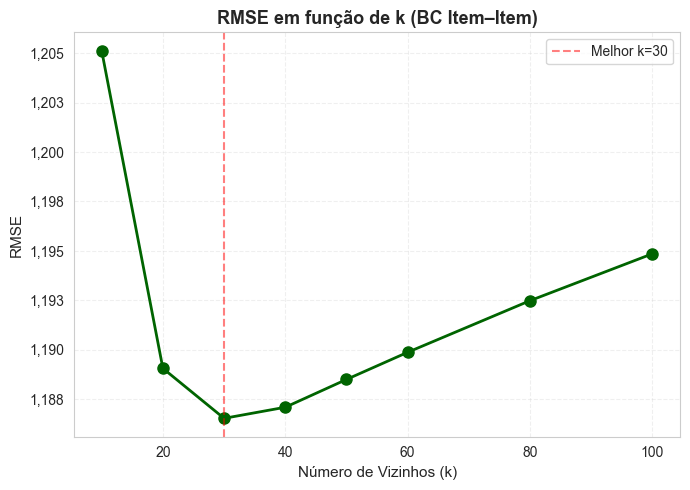

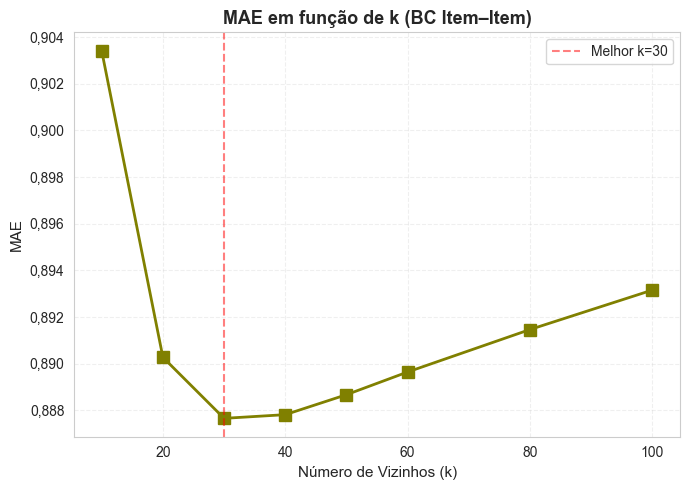

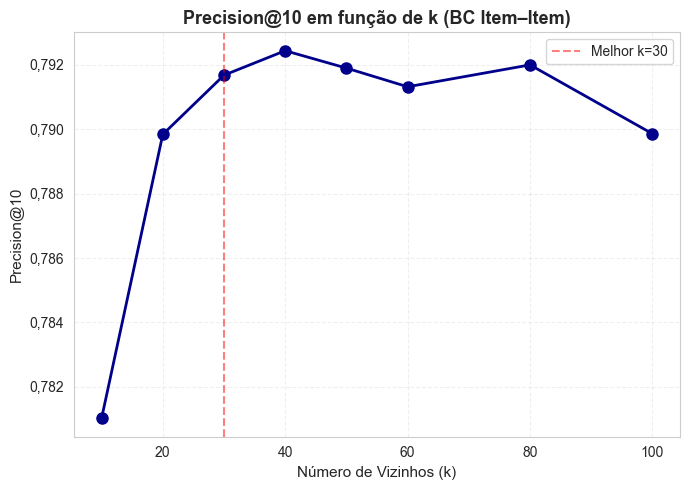

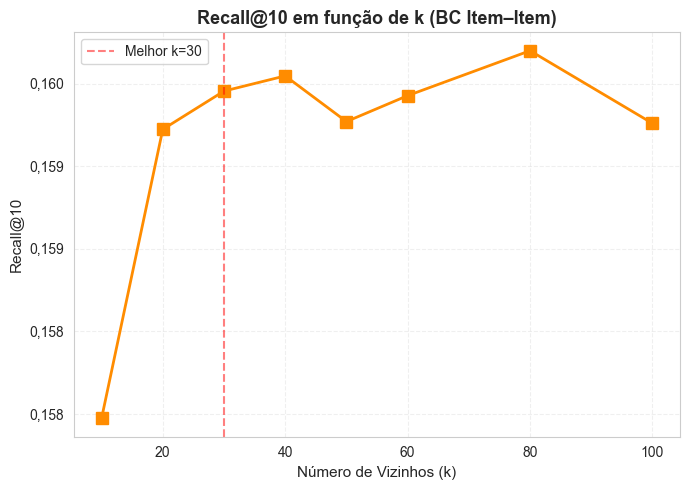


✅ ANÁLISE BC ITEM-ITEM COMPLETA!

Variáveis disponíveis para comparação:
  - best_k_bc = 30
  - y_true_bc: array com 443561 valores reais
  - y_pred_bc: array com 443561 predições (k=30)
  - pred_series_bc: Series com MultiIndex
  - preds_per_k_bc: dict com predições para cada k
  - rmse_bc = 1.0915
  - mae_bc = 0.8179
  - precision_bc = 0.7917
  - recall_bc = 0.1595
  - results_bc: dict com todas as métricas


In [78]:
# ============================================================================
# 9. GRÁFICOS
# ============================================================================

print("\nGerando gráficos...")

# ----------------------------------------------------------------
# GRÁFICO 1: MÉTRICAS DE ACURÁCIA (RMSE e MAE) — LADO A LADO
# ----------------------------------------------------------------

# RMSE
plt.figure(figsize=(7, 5))

plt.plot(k_values_bc, rmse_results_bc,
         marker='o', linewidth=2, markersize=8, color='darkgreen')

plt.axvline(x=best_k_bc, color='red', linestyle='--', alpha=0.5,
            label=f'Melhor k={best_k_bc}')

plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('RMSE', fontsize=11)
plt.title('RMSE em função de k (BC Item–Item)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/bc_rmse_k.png', dpi=300, bbox_inches='tight')
plt.show()


# MAE
plt.figure(figsize=(7, 5))

plt.plot(k_values_bc, mae_results_bc,
         marker='s', linewidth=2, markersize=8, color='olive')

plt.axvline(x=best_k_bc, color='red', linestyle='--', alpha=0.5,
            label=f'Melhor k={best_k_bc}')

plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('MAE', fontsize=11)
plt.title('MAE em função de k (BC Item–Item)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/bc_mae_k.png', dpi=300, bbox_inches='tight')
plt.show()



# ----------------------------------------------------------------
# GRÁFICO 2: MÉTRICAS DE RANKING (Precision@10 e Recall@10) — LADO A LADO
# ----------------------------------------------------------------

# Precision@10
plt.figure(figsize=(7, 5))

plt.plot(k_values_bc, precision_results_bc,
         marker='o', linewidth=2, markersize=8, color='darkblue')

plt.axvline(x=best_k_bc, color='red', linestyle='--', alpha=0.5,
            label=f'Melhor k={best_k_bc}')

plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('Precision@10', fontsize=11)
plt.title('Precision@10 em função de k (BC Item–Item)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/bc_precision_k.png', dpi=300, bbox_inches='tight')
plt.show()


# Recall@10
plt.figure(figsize=(7, 5))

plt.plot(k_values_bc, recall_results_bc,
         marker='s', linewidth=2, markersize=8, color='darkorange')

plt.axvline(x=best_k_bc, color='red', linestyle='--', alpha=0.5,
            label=f'Melhor k={best_k_bc}')

plt.xlabel('Número de Vizinhos (k)', fontsize=11)
plt.ylabel('Recall@10', fontsize=11)
plt.title('Recall@10 em função de k (BC Item–Item)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
)

plt.tight_layout()
plt.savefig('images/bc_recall_k.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*80)
print("✅ ANÁLISE BC ITEM-ITEM COMPLETA!")
print("="*80)
print("\nVariáveis disponíveis para comparação:")
print(f"  - best_k_bc = {best_k_bc}")
print(f"  - y_true_bc: array com {len(y_true_bc)} valores reais")
print(f"  - y_pred_bc: array com {len(y_pred_bc)} predições (k={best_k_bc})")
print(f"  - pred_series_bc: Series com MultiIndex")
print(f"  - preds_per_k_bc: dict com predições para cada k")
print(f"  - rmse_bc = {rmse_bc:.4f}")
print(f"  - mae_bc = {mae_bc:.4f}")
print(f"  - precision_bc = {precision_bc:.4f}")
print(f"  - recall_bc = {recall_bc:.4f}")
print(f"  - results_bc: dict com todas as métricas")

## **Modelo Híbrido**

### 1. Resumo das Métricas Ajustadas dos Modelos Anteriores

In [37]:
import pandas as pd

df_comparacao = pd.DataFrame({
    'RMSE': [rmse_fc, rmse_bl, rmse_bc],
    'MAE': [mae_fc, mae_bl, mae_bc],
    'PREC': [precision_fc, precision_bl, precision_bc],
    'RECALL': [recall_fc, recall_bl, recall_bc]
}, index=['FC', 'Baseline', 'BC'])
# Se tiver baseline, adicione:
# }, index=['FC', 'BC', 'Baseline'])
# E inclua rmse_bl, mae_bl, precision_bl, recall_bl nas listas

print(df_comparacao)

              RMSE       MAE      PREC    RECALL
FC        1.089512  0.815884  0.870874  0.178143
Baseline  1.114084  0.835240  0.848850  0.172081
BC        1.186537  0.887661  0.791678  0.159456


### 2. Predição do Modelo Híbrido (FC + BL) e (FC + BC)

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

print("="*80)
print("ANÁLISE COMPARATIVA: MODELO HÍBRIDO FC+BL vs FC+BC")
print("="*80)

# ============================================================================
# 1. CONFIGURAÇÃO
# ============================================================================

beta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
N_RANKING = 10
RELEVANCE_THRESHOLD = 7.0

print(f"\nValores de beta a testar: {beta_values}")
print(f"Beta = 0.0 → 100% Baseline/BC")
print(f"Beta = 1.0 → 100% FC")

ANÁLISE COMPARATIVA: MODELO HÍBRIDO FC+BL vs FC+BC

Valores de beta a testar: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Beta = 0.0 → 100% Baseline/BC
Beta = 1.0 → 100% FC


In [80]:
# ============================================================================
# 2. FUNÇÃO HÍBRIDA
# ============================================================================

def hybrid_late_fusion(y_pred_1, y_pred_2, beta):
    """Combina duas predições usando late fusion."""
    y_hybrid = beta * y_pred_1 + (1 - beta) * y_pred_2
    
    # Fallback: se FC for NaN, usa o outro modelo
    mask = np.isnan(y_pred_1)
    y_hybrid[mask] = y_pred_2[mask]
    
    # Fallback: se o outro modelo for NaN, usa FC
    mask = np.isnan(y_pred_2)
    y_hybrid[mask] = y_pred_1[mask]
    
    return np.clip(y_hybrid, 1.0, 10.0)

# ============================================================================
# 3. VERIFICAÇÃO DAS PREDIÇÕES BASE
# ============================================================================

print("\n" + "="*80)
print("VERIFICAÇÃO DOS MODELOS BASE")
print("="*80)

# Verificar disponibilidade
models_ok = True

if 'y_pred_fc' not in dir():
    print("✗ FC não encontrado")
    models_ok = False
else:
    print(f"✓ FC encontrado (shape: {y_pred_fc.shape}, NaNs: {np.isnan(y_pred_fc).sum()})")

if 'y_pred_bl' not in dir():
    print("✗ Baseline não encontrado")
    models_ok = False
else:
    print(f"✓ Baseline encontrado (shape: {y_pred_bl.shape}, NaNs: {np.isnan(y_pred_bl).sum()})")

if 'y_pred_bc' not in dir():
    print("✗ BC não encontrado")
    models_ok = False
else:
    print(f"✓ BC encontrado (shape: {y_pred_bc.shape}, NaNs: {np.isnan(y_pred_bc).sum()})")

if not models_ok:
    print("\n⚠️ ERRO: Execute as células dos modelos base primeiro!")
else:
    # Usar y_true do FC
    y_true = y_true_fc if 'y_true_fc' in dir() else test_df['Rating'].values
    print(f"✓ y_true (shape: {y_true.shape})")




VERIFICAÇÃO DOS MODELOS BASE
✓ FC encontrado (shape: (443561,), NaNs: 0)
✓ Baseline encontrado (shape: (443561,), NaNs: 0)
✓ BC encontrado (shape: (443561,), NaNs: 0)
✓ y_true (shape: (443561,))



CALCULANDO PREDIÇÕES HÍBRIDAS
Beta=0.0 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.1 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.2 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.3 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.4 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.5 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.6 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.7 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.8 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=0.9 -> FC+BL NaNs: 0, FC+BC NaNs: 0
Beta=1.0 -> FC+BL NaNs: 0, FC+BC NaNs: 0

MÉTRICAS DE ACURÁCIA

Beta   FC+BL RMSE   FC+BL MAE    FC+BC RMSE   FC+BC MAE   
------------------------------------------------------------
0.0    1.1141       0.8352       1.1865       0.8877      
0.1    1.1091       0.8310       1.1644       0.8696      
0.2    1.1047       0.8273       1.1448       0.8537      
0.3    1.1009       0.8241       1.1278       0.8402      
0.4    1.0977       0.8215       1.1136       0.8291      
0.5    1.0952       0.8195       1.1023       0.8205      
0.6    1.0932       0

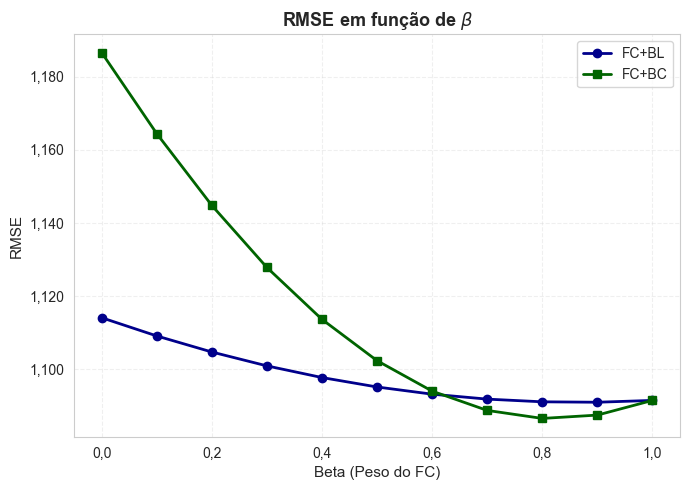

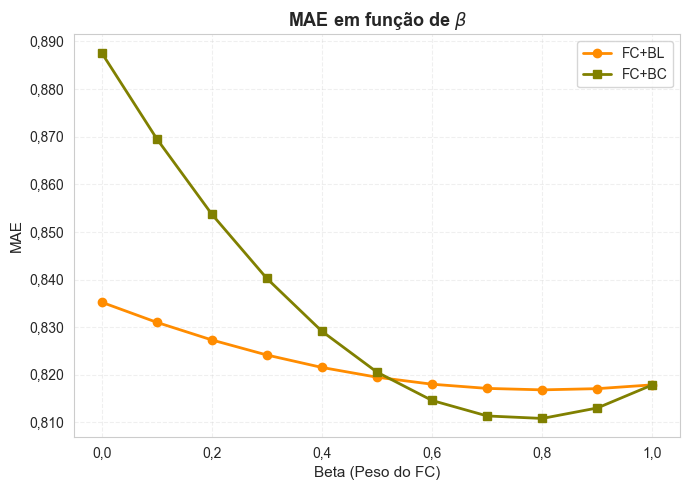

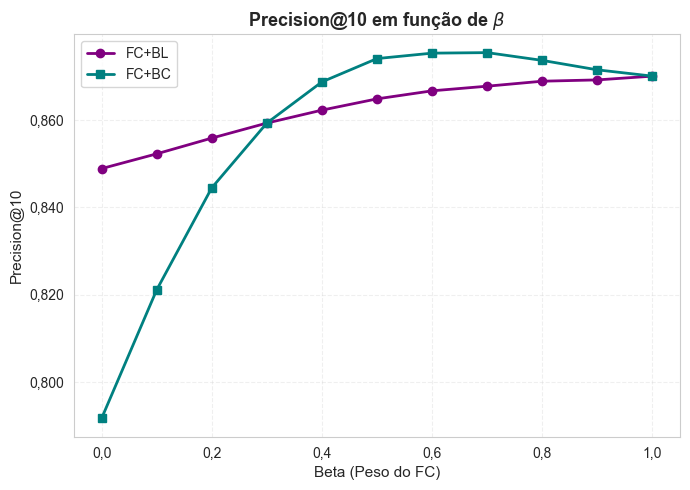

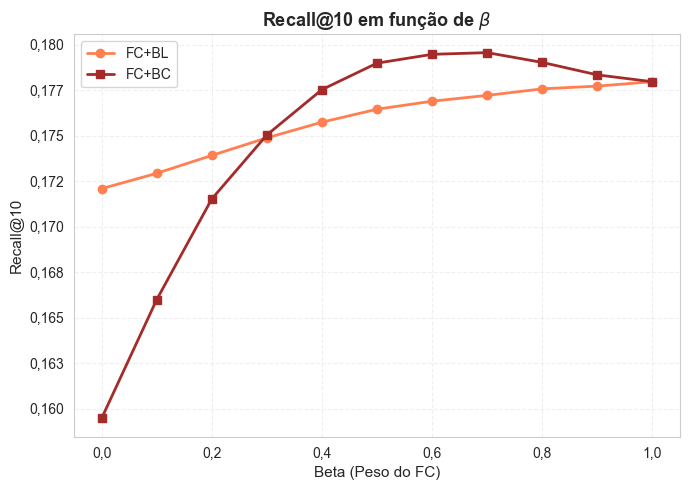


✓ DataFrame comparativo salvo: df_comparison

✅ ANÁLISE COMPARATIVA COMPLETA!


In [76]:
# ============================================================================
# 4. CALCULAR PREDIÇÕES PARA AMBOS OS HÍBRIDOS
# ============================================================================

if models_ok:
    print("\n" + "="*80)
    print("CALCULANDO PREDIÇÕES HÍBRIDAS")
    print("="*80)
    
    preds_fc_bl = {}  # FC + Baseline
    preds_fc_bc = {}  # FC + BC
    
    for beta in beta_values:
        # FC + Baseline
        y_pred_fc_bl = hybrid_late_fusion(y_pred_fc, y_pred_bl, beta)
        preds_fc_bl[beta] = y_pred_fc_bl
        
        # FC + BC
        y_pred_fc_bc = hybrid_late_fusion(y_pred_fc, y_pred_bc, beta)
        preds_fc_bc[beta] = y_pred_fc_bc
        
        print(f"Beta={beta:.1f} -> FC+BL NaNs: {np.isnan(y_pred_fc_bl).sum()}, "
              f"FC+BC NaNs: {np.isnan(y_pred_fc_bc).sum()}")
    
    # ========================================================================
    # 5. MÉTRICAS DE ACURÁCIA
    # ========================================================================
    
    print("\n" + "="*80)
    print("MÉTRICAS DE ACURÁCIA")
    print("="*80)
    
    rmse_fc_bl = []
    mae_fc_bl = []
    rmse_fc_bc = []
    mae_fc_bc = []
    
    print(f"\n{'Beta':<6} {'FC+BL RMSE':<12} {'FC+BL MAE':<12} {'FC+BC RMSE':<12} {'FC+BC MAE':<12}")
    print("-"*60)
    
    for beta in beta_values:
        # FC + BL
        rmse_bl, mae_bl = calculate_accuracy_metrics(y_true, preds_fc_bl[beta])
        rmse_fc_bl.append(rmse_bl)
        mae_fc_bl.append(mae_bl)
        
        # FC + BC
        rmse_bc, mae_bc = calculate_accuracy_metrics(y_true, preds_fc_bc[beta])
        rmse_fc_bc.append(rmse_bc)
        mae_fc_bc.append(mae_bc)
        
        print(f"{beta:<6.1f} {rmse_bl:<12.4f} {mae_bl:<12.4f} {rmse_bc:<12.4f} {mae_bc:<12.4f}")
    
    # ========================================================================
    # 6. MÉTRICAS DE RANKING
    # ========================================================================
    
    print("\n" + "="*80)
    print("MÉTRICAS DE RANKING")
    print("="*80)
    
    precision_fc_bl = []
    recall_fc_bl = []
    precision_fc_bc = []
    recall_fc_bc = []
    
    for beta in beta_values:
        print(f"\nCalculando P@{N_RANKING} e R@{N_RANKING} para beta={beta:.1f}...")
        
        # FC + BL
        predictions_dict = {}
        for idx, row in enumerate(test_df.itertuples(index=False)):
            predictions_dict[(row.Username, row.BGGId)] = preds_fc_bl[beta][idx]
        
        pred_series = pd.Series(
            predictions_dict,
            index=pd.MultiIndex.from_tuples(predictions_dict.keys(), names=['Username', 'BGGId'])
        )
        predictions_df = pred_series.unstack()
        
        prec_bl, rec_bl = calculate_ranking_metrics(
            R_train, R_test, predictions_df,
            relevance_threshold=RELEVANCE_THRESHOLD, N=N_RANKING
        )
        precision_fc_bl.append(prec_bl)
        recall_fc_bl.append(rec_bl)
        
        # FC + BC
        predictions_dict = {}
        for idx, row in enumerate(test_df.itertuples(index=False)):
            predictions_dict[(row.Username, row.BGGId)] = preds_fc_bc[beta][idx]
        
        pred_series = pd.Series(
            predictions_dict,
            index=pd.MultiIndex.from_tuples(predictions_dict.keys(), names=['Username', 'BGGId'])
        )
        predictions_df = pred_series.unstack()
        
        prec_bc, rec_bc = calculate_ranking_metrics(
            R_train, R_test, predictions_df,
            relevance_threshold=RELEVANCE_THRESHOLD, N=N_RANKING
        )
        precision_fc_bc.append(prec_bc)
        recall_fc_bc.append(rec_bc)
        
        print(f"  FC+BL -> P@{N_RANKING}: {prec_bl:.4f} | R@{N_RANKING}: {rec_bl:.4f}")
        print(f"  FC+BC -> P@{N_RANKING}: {prec_bc:.4f} | R@{N_RANKING}: {rec_bc:.4f}")
    
    # ========================================================================
    # 7. RESUMO COMPARATIVO
    # ========================================================================
    
    print("\n" + "="*80)
    print("RESUMO COMPARATIVO")
    print("="*80)
    
    print(f"\n{'Beta':<6} {'Modelo':<10} {'RMSE':<10} {'MAE':<10} {'Prec@10':<10} {'Rec@10':<10}")
    print("-"*60)
    for i, beta in enumerate(beta_values):
        print(f"{beta:<6.1f} {'FC+BL':<10} {rmse_fc_bl[i]:<10.4f} {mae_fc_bl[i]:<10.4f} "
              f"{precision_fc_bl[i]:<10.4f} {recall_fc_bl[i]:<10.4f}")
        print(f"{'':6} {'FC+BC':<10} {rmse_fc_bc[i]:<10.4f} {mae_fc_bc[i]:<10.4f} "
              f"{precision_fc_bc[i]:<10.4f} {recall_fc_bc[i]:<10.4f}")
        print()
    
    # Identificar melhores
    best_rmse_bl_idx = np.argmin(rmse_fc_bl)
    best_rmse_bc_idx = np.argmin(rmse_fc_bc)
    
    print("="*80)
    print("MELHOR BETA POR MODELO")
    print("="*80)
    print(f"\nFC+BL: Beta={beta_values[best_rmse_bl_idx]:.1f} (RMSE={rmse_fc_bl[best_rmse_bl_idx]:.4f})")
    print(f"FC+BC: Beta={beta_values[best_rmse_bc_idx]:.1f} (RMSE={rmse_fc_bc[best_rmse_bc_idx]:.4f})")
    
    # ========================================================================
    # 8. GRÁFICOS COMPARATIVOS
    # ========================================================================
    
    print("\nGerando gráficos comparativos...")
    
    # ----------------------------------------------------------------
    # GRÁFICO 1: RMSE e MAE LADO A LADO
    # ----------------------------------------------------------------
    
    # RMSE VS BETA
    plt.figure(figsize=(7, 5))

    plt.plot(beta_values, rmse_fc_bl, marker='o', linewidth=2,
            color='darkblue', label='FC+BL')
    plt.plot(beta_values, rmse_fc_bc, marker='s', linewidth=2,
            color='darkgreen', label='FC+BC')

    plt.xlabel('Beta (Peso do FC)', fontsize=11)
    plt.ylabel('RMSE', fontsize=11)
    plt.title('RMSE em função de $\\beta$', fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()

    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
    )

    plt.tight_layout()
    plt.savefig('images/hybrid_rmse_beta.png', dpi=300, bbox_inches='tight')
    plt.show()
    

    # MAE VS BETA
    plt.figure(figsize=(7, 5))

    plt.plot(beta_values, mae_fc_bl, marker='o', linewidth=2,
            color='darkorange', label='FC+BL')
    plt.plot(beta_values, mae_fc_bc, marker='s', linewidth=2,
            color='olive', label='FC+BC')

    plt.xlabel('Beta (Peso do FC)', fontsize=11)
    plt.ylabel('MAE', fontsize=11)
    plt.title('MAE em função de $\\beta$', fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()

    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
    )

    plt.tight_layout()
    plt.savefig('images/hybrid_mae_beta.png', dpi=300, bbox_inches='tight')
    plt.show()



    # ----------------------------------------------------------------
    # GRÁFICO 2: PRECISION E RECALL 
    # ----------------------------------------------------------------
    
    # PRECISION VS BETA
    plt.figure(figsize=(7, 5))

    plt.plot(beta_values, precision_fc_bl, marker='o', linewidth=2,
            color='purple', label='FC+BL')
    plt.plot(beta_values, precision_fc_bc, marker='s', linewidth=2,
            color='teal', label='FC+BC')

    plt.xlabel('Beta (Peso do FC)', fontsize=11)
    plt.ylabel('Precision@10', fontsize=11)
    plt.title('Precision@10 em função de $\\beta$', fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()

    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
    )

    plt.tight_layout()
    plt.savefig('images/hybrid_precision_beta.png', dpi=300, bbox_inches='tight')
    plt.show()


    # RECALL VS BETA

    plt.figure(figsize=(7, 5))

    plt.plot(beta_values, recall_fc_bl, marker='o', linewidth=2,
            color='coral', label='FC+BL')
    plt.plot(beta_values, recall_fc_bc, marker='s', linewidth=2,
            color='brown', label='FC+BC')

    plt.xlabel('Beta (Peso do FC)', fontsize=11)
    plt.ylabel('Recall@10', fontsize=11)
    plt.title('Recall@10 em função de $\\beta$', fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()

    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ','))
    )

    plt.tight_layout()
    plt.savefig('images/hybrid_recall_beta.png', dpi=300, bbox_inches='tight')
    plt.show()


    
    # ========================================================================
    # 9. DATAFRAME COMPARATIVO
    # ========================================================================
    
    df_comparison = pd.DataFrame({
        'Beta': beta_values,
        'FC+BL_RMSE': rmse_fc_bl,
        'FC+BC_RMSE': rmse_fc_bc,
        'FC+BL_MAE': mae_fc_bl,
        'FC+BC_MAE': mae_fc_bc,
        'FC+BL_Prec': precision_fc_bl,
        'FC+BC_Prec': precision_fc_bc,
        'FC+BL_Rec': recall_fc_bl,
        'FC+BC_Rec': recall_fc_bc
    })
    
    print("\n✓ DataFrame comparativo salvo: df_comparison")
    
    print("\n" + "="*80)
    print("✅ ANÁLISE COMPARATIVA COMPLETA!")
    print("="*80)

----

## Teste de recomendações para um novo user

In [ ]:
# import pandas as pd
# import numpy as np

# # Parâmetros de Ponderação (ALPHA) e K_ITEMS (devem ser definidos no seu script principal)
# BETA = 0.5 
# K_ITEMS = 30 

# def predict_baseline_cold_start(item_id, mu, bi):
#     """Calcula a previsão do Baseline (Cold Start User) usando apenas Mu e o viés do Item (bi)."""
#     bi_val = bi.get(item_id, 0.0) 
#     return mu + bi_val

# def recommend_new_user_hybrid(new_user_ratings, R_train, sim_bc_jaccard, mu, bi, games_df, beta=0.5, N_RECS=5):
#     """
#     Recomenda N_RECS itens para um novo usuário usando o modelo Híbrido (BC + Baseline).

#     **Versão Robusta contra KeyError:** Filtra itens do usuário e candidatos que não estão 
#     na matriz de similaridade (sim_bc_jaccard).

#     Args:
#         new_user_ratings (dict): {item_id: rating}
#         games_df (DataFrame): DataFrame com colunas 'BGGId' e 'Name' para mapeamento.
#         [Outros Parâmetros]: Parâmetros calculados do modelo.
#     """
    
#     # --- 1. PREPARAÇÃO E FILTRAGEM DE ITENS ---
    
#     # Criar mapeamento BGGId para Nome
#     game_name_map = games_df.set_index('BGGId')['Name'].to_dict()
    
#     # Itens conhecidos (que estão no índice/colunas da matriz de similaridade)
#     all_known_items = sim_bc_jaccard.index
    
#     # Filtrar o histórico do usuário para manter apenas itens que o modelo "conhece"
#     # (Ou seja, itens que estão na matriz sim_bc_jaccard). ISSO CORRIGE O KEYERROR.
#     filtered_ratings = {
#         item_id: rating 
#         for item_id, rating in new_user_ratings.items() 
#         if item_id in all_known_items
#     }
#     rated_items_ids = list(filtered_ratings.keys())
    
#     # Determinar os itens candidatos (todos os itens conhecidos, exceto os que o usuário já avaliou)
#     candidate_items = [item for item in all_known_items if item not in rated_items_ids]
    
#     predictions = {}
    
#     # --- 2. GERAÇÃO DE PREVISÕES ---
#     for item_id in candidate_items:
        
#         # B. Previsão Baseline Cold Start (Sempre calculável, usado como fallback)
#         pred_base = predict_baseline_cold_start(item_id, mu, bi)
        
#         # A. Previsão BC Item-Item
#         pred_bc = np.nan
        
#         # Só calcula o BC se o usuário tiver avaliado pelo menos um item conhecido
#         if rated_items_ids: 
#             # item_id (candidato) e rated_items_ids (vizinhos) são garantidamente 
#             # encontrados em sim_bc_jaccard, prevenindo o KeyError.
#             similarities = sim_bc_jaccard.loc[item_id, rated_items_ids]
            
#             numerator = 0
#             denominator_abs = 0
            
#             for rated_item_id, rating in filtered_ratings.items():
#                 sim_val = similarities.loc[rated_item_id]
#                 numerator += sim_val * rating
#                 denominator_abs += abs(sim_val)
            
#             if denominator_abs > 0:
#                 pred_bc = numerator / denominator_abs
        
#         # C. Combinação Híbrida
#         # Usa o Baseline se o BC não puder ser calculado (np.isnan(pred_bc) ou rated_items_ids vazio)
#         final_pred = pred_base if np.isnan(pred_bc) else beta * pred_bc + (1 - beta) * pred_base
        
#         predictions[item_id] = np.clip(final_pred, 1.0, 10.0)

#     # --- 3. GERAR, MAPEAR E RETORNAR RECOMENDAÇÕES ---
#     # Transforma o dicionário de previsões em Série e pega os Top N
#     recommendations = pd.Series(predictions).sort_values(ascending=False).head(N_RECS)
    
#     # Mapear o BGGId (índice atual) para o Nome do Jogo
#     recommendations.index = recommendations.index.map(game_name_map)
    
#     # Retorna a Série com o Nome do Jogo no índice
#     return recommendations

In [ ]:
# usernames_faltantes_unicos = ratings_original[
#     ~ratings_original['Username'].isin(ratings['Username'])
# ]['Username'].unique()

# USER_TESTE = ratings_original[ratings_original['Username'].isin(usernames_faltantes_unicos)]['Username'].value_counts().sort_values(ascending=False).index[0]  # Pega o usuário com mais avaliações


In [ ]:
# import pandas as pd
# import numpy as np

# # --- 1. Selecionar Usuário e Avaliações ---
# # Seleciona o primeiro usuário da matriz de treino
# USER_SIMULATED_ID = USER_TESTE

# # Pega todas as avaliações deste usuário (que estão em R_train)
# all_user_ratings = ratings_original[ratings_original['Username'] == USER_TESTE].dropna()
# all_user_ratings = all_user_ratings.set_index('BGGId')['Rating']
# # Pega apenas 10 dessas avaliações para simular um histórico inicial (Cold Start)
# if len(all_user_ratings) > 5:
#     # Cria o dicionário {BGGId: Rating} de entrada
#     NEW_USER_RATINGS_SIMULATED = all_user_ratings.head(5).to_dict() 
# else:
#     # Se ele tiver menos de 10, usa todas
#     NEW_USER_RATINGS_SIMULATED = all_user_ratings.to_dict() 

# # O conjunto de treino/similaridade NÃO deve conter essas 10 avaliações.
# # Para um teste 100% puro, você deveria remover essas 10 notas do R_train antes de calcular mu, bi, e similaridades. 
# # No entanto, para o teste da função, vamos prosseguir com os modelos já calculados.


# # --- 2. Gerar Recomendações com o Modelo Híbrido ---
# # As variáveis sim_bc_jaccard, mu, bi (e alpha=0.5) devem estar definidas

# # Supondo que as variáveis de modelo (R_train, sim_bc_jaccard, mu, bi) 
# # e o DataFrame de jogos (games) estão definidos, 
# # e que NEW_USER_RATINGS_SIMULATED foi gerado na etapa anterior.

# recommendations_final = recommend_new_user_hybrid(
#     NEW_USER_RATINGS_SIMULATED, 
#     R_train, 
#     sim_bc_jaccard, 
#     mu, 
#     bi, 
#     games,  # NOVO ARGUMENTO
#     alpha=0.5, 
#     N_RECS=5
# )

# print("\n--- Recomendações Finais com Nome do Jogo (Híbrido Cold Start) ---")
# print(recommendations_final)

TypeError: recommend_new_user_hybrid() got an unexpected keyword argument 'alpha'

In [ ]:
# import pandas as pd
# import numpy as np

# # --- Assumimos que:
# # 1. NEW_USER_RATINGS_SIMULATED (dicionário {BGGId: Rating}) está definido.
# # 2. recommendations_final (Série [Game Name: Predicted Rating]) está definido.
# # 3. games (DataFrame com BGGId e Name) está definido.
# # 4. game_name_map (dicionário {BGGId: Name}) está definido.
# # -------------------------------------------------------------

# # 1. Formatar a Tabela de Avaliações Dadas (Histórico)

# # Converter o dicionário de avaliações do novo usuário para um DataFrame
# df_rated = pd.DataFrame(
#     list(NEW_USER_RATINGS_SIMULATED.items()), 
#     columns=['BGGId', 'Real Rating']
# )

# # Criar mapeamento BGGId para Nome
# game_name_map = games.set_index('BGGId')['Name'].to_dict()

# # Mapear o BGGId para o Nome do Jogo
# df_rated['Game Name'] = df_rated['BGGId'].map(game_name_map)

# # Selecionar e ordenar as colunas para apresentação
# df_rated_final = df_rated[['Game Name', 'Real Rating']].sort_values(
#     by='Real Rating', 
#     ascending=False
# ).reset_index(drop=True)


# # 2. Formatar a Tabela de Recomendações (Previsões)

# # recommendations_final já é uma Série ordenada, apenas a convertemos em DataFrame
# df_recommended_final = recommendations_final.to_frame(name='Predicted Rating').reset_index()
# df_recommended_final.columns = ['Game Name', 'Predicted Rating'] # Renomear o índice para Game Name

# # 3. Apresentação Final

# print("\n--- 📝 Histórico de Avaliações do Usuário Cold Start ---")
# print(f"Total de jogos avaliados: {len(df_rated_final)}\n")
# print(df_rated_final)

# print("\n\n--- 🚀 Recomendações Híbridas (Top 5) ---")
# print("Ordenado pela Nota Prevista Decrescente\n")
# print(df_recommended_final)


--- 📝 Histórico de Avaliações do Usuário Cold Start ---
Total de jogos avaliados: 5

   Game Name  Real Rating
0      Catan         10.0
1  RoboRally          9.0
2   Bohnanza          7.0
3         Ra          7.0
4     Basari          6.0


--- 🚀 Recomendações Híbridas (Top 5) ---
Ordenado pela Nota Prevista Decrescente

                             Game Name  Predicted Rating
0             Hansa Teutonica: Big Box          9.189281
1                             Cascadia          9.124571
2                         Gaia Project          9.063534
3  Eclipse: Second Dawn for the Galaxy          9.035232
4                            Destinies          9.023474


## Simulação de Hold-Out (Avaliação "Esquecida")



Esta técnica é conhecida como **Hold-Out** ou **Leave-One-Out (ou K-Out)** e é crucial para validar a **precisão** do modelo, especialmente em cenários de Cold Start.

Para implementar isso, vamos modificar o fluxo de simulação:

1.  **Separar o Histórico:** Dividir as avaliações reais do usuário em dois grupos:
      * **Histórico de Treino (Input):** As 5 avaliações que o modelo "conhece" para gerar a similaridade BC.
      * **Hold-Out (Target):** As 5 avaliações que o modelo **vai tentar prever** (os jogos "esquecidos").
2.  **Gerar Previsões:** Chamar a função `recommend_new_user_hybrid` usando apenas o **Histórico de Treino** como entrada.
3.  **Comparar:** Filtrar as previsões para obter apenas os jogos que estão no conjunto **Hold-Out** e comparar a nota prevista com a nota real.

Abaixo está o código modificado para alcançar esse objetivo, assumindo as mesmas variáveis de contexto (`ratings_original`, `games`, `R_train`, `sim_bc_jaccard`, `mu`, `bi`) que você usou anteriormente.

-----



### Código Modificado para Comparação


In [146]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

print("="*80)
print("TESTE DE COLD START: NOVO USUÁRIO - FC+BL vs FC+BC")
print("="*80)

# ============================================================================
# 1. SELECIONAR USUÁRIO COLD START (NÃO ESTÁ NO TREINO)
# ============================================================================

print("\nSelecionando usuário cold start...")

# Usuários que NÃO estão no treino
usuarios_fora_treino = ratings_original[
    ~ratings_original['Username'].isin(R_train.index)
]['Username'].unique()

print(f"Usuários fora do treino: {len(usuarios_fora_treino)}")

# Selecionar usuário com pelo menos 10 avaliações
usuarios_com_historico = ratings_original[
    ratings_original['Username'].isin(usuarios_fora_treino)
].groupby('Username').size()

usuarios_validos = usuarios_com_historico[usuarios_com_historico >= 100].index



TESTE DE COLD START: NOVO USUÁRIO - FC+BL vs FC+BC

Selecionando usuário cold start...
Usuários fora do treino: 400590


In [82]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings

# Ignora avisos de warnings do Python
warnings.filterwarnings('ignore')

# Ignora erros de divisão por zero ou valores inválidos no NumPy
np.seterr(divide='ignore', invalid='ignore')


print("="*80)
print("TESTE DE COLD START: NOVO USUÁRIO - FC+BL vs FC+BC")
print("="*80)

# ============================================================================
# 1. SELECIONAR USUÁRIO COLD START (NÃO ESTÁ NO TREINO)
# ============================================================================

print("\nSelecionando usuário cold start...")

# Usuários que NÃO estão no treino
usuarios_fora_treino = ratings_original[
    ~ratings_original['Username'].isin(R_train.index)
]['Username'].unique()

print(f"Usuários fora do treino: {len(usuarios_fora_treino)}")

# Selecionar usuário com pelo menos 10 avaliações
usuarios_com_historico = ratings_original[
    ratings_original['Username'].isin(usuarios_fora_treino)
].groupby('Username').size()

usuarios_validos = usuarios_com_historico[usuarios_com_historico >= 100].index

if len(usuarios_validos) == 0:
    print("⚠️ Nenhum usuário válido encontrado!")
else:
    # Pegar o usuário com mais avaliações
    USER_COLD_START = ratings_original[
        ratings_original['Username'].isin(usuarios_validos)
    ]['Username'].value_counts().index[0]
    
    print(f"✓ Usuário selecionado: {USER_COLD_START}")
    
    # ========================================================================
    # 2. PREPARAR DADOS DO USUÁRIO (FILTRAR APENAS ITENS EM R_TRAIN)
    # ========================================================================
    
    # Todas as avaliações do usuário
    all_user_ratings_raw = ratings_original[
        ratings_original['Username'] == USER_COLD_START
    ].set_index('BGGId')['Rating']
    
    # ⚠️ CORREÇÃO: Filtrar apenas itens que existem em R_train
    all_user_ratings = all_user_ratings_raw[all_user_ratings_raw.index.isin(R_train.columns)]
    
    print(f"  Total de avaliações do usuário: {len(all_user_ratings_raw)}")
    print(f"  Avaliações de itens conhecidos (em R_train): {len(all_user_ratings)}")
    
    if len(all_user_ratings) < 10:
        print("⚠️ Usuário não tem avaliações suficientes de itens conhecidos!")
    else:
        # Separar 5 jogos para teste e resto para "histórico conhecido"
        np.random.seed(42)
        test_games = np.random.choice(all_user_ratings.index, size=5, replace=False)
        
        # Histórico conhecido (para fazer predições)
        known_ratings = all_user_ratings.drop(test_games).to_dict()
        
        # Jogos teste (para comparar)
        test_ratings_real = all_user_ratings[test_games]
        
        print(f"  Jogos no histórico conhecido: {len(known_ratings)}")
        print(f"  Jogos para testar (esquecidos): {len(test_games)}")
        
        # ====================================================================
        # 3. FUNÇÃO DE PREDIÇÃO HÍBRIDA PARA COLD START (CORRIGIDA)
        # ====================================================================
        
        def predict_hybrid_cold_start(item_id, known_ratings_dict, R_train, 
                                       sim_matrix_user, sim_matrix_item, user_means,
                                       beta=0.6, use_bc=True, mu=None, bi=None, k=50):
            """
            Prevê nota para um novo usuário (cold start) usando modelo híbrido.
            """
            
            # ⚠️ VERIFICAR SE ITEM EXISTE EM R_TRAIN
            if item_id not in R_train.columns:
                # Item não está na base de treino, usar apenas modelo baseado em conteúdo
                if use_bc and sim_matrix_item is not None and len(known_ratings_dict) > 0:
                    if item_id in sim_matrix_item.index:
                        valid_items = [i for i in known_ratings_dict.keys() 
                                      if i in sim_matrix_item.columns]
                        
                        if len(valid_items) > 0:
                            sims = sim_matrix_item.loc[item_id, valid_items]
                            ratings = pd.Series([known_ratings_dict[i] for i in valid_items], 
                                               index=valid_items)
                            
                            denominator = sims.abs().sum()
                            if denominator > 0:
                                numerator = (sims * ratings).sum()
                                return np.clip(numerator / denominator, 1.0, 10.0)
                
                # Fallback: média do usuário ou baseline
                if use_bc:
                    return np.mean(list(known_ratings_dict.values())) if len(known_ratings_dict) > 0 else np.nan
                elif mu is not None and bi is not None:
                    bi_val = bi.get(item_id, 0.0)
                    return np.clip(mu + bi_val, 1.0, 10.0)
                else:
                    return np.nan
            
            # --- PREDIÇÃO FC USER-USER ---
            if len(known_ratings_dict) == 0:
                pred_fc = np.nan
            else:
                # Calcular similaridade do novo usuário com usuários do treino
                common_items = [i for i in known_ratings_dict.keys() if i in R_train.columns]
                
                if len(common_items) == 0:
                    pred_fc = np.nan
                else:
                    similarities = {}
                    
                    for train_user in R_train.index:
                        train_ratings = R_train.loc[train_user, common_items].dropna()
                        
                        if len(train_ratings) >= 2:
                            new_user_ratings = pd.Series([known_ratings_dict[i] for i in train_ratings.index])
                            
                            if new_user_ratings.std() > 0 and train_ratings.std() > 0:
                                corr = new_user_ratings.corr(train_ratings)
                                if not np.isnan(corr):
                                    similarities[train_user] = corr
                    
                    if len(similarities) == 0:
                        pred_fc = np.nan
                    else:
                        sim_series = pd.Series(similarities)
                        
                        # Filtrar usuários que avaliaram o item alvo
                        rated_item = R_train[item_id].dropna().index
                        sim_series = sim_series[sim_series.index.isin(rated_item)]
                        
                        if len(sim_series) == 0:
                            pred_fc = np.nan
                        else:
                            top_k_users = sim_series.abs().nlargest(k).index
                            
                            sim_k = sim_series[top_k_users]
                            ratings_k = R_train.loc[top_k_users, item_id]
                            means_k = user_means[top_k_users]
                            
                            new_user_mean = np.mean(list(known_ratings_dict.values()))
                            
                            denominator = sim_k.abs().sum()
                            
                            if denominator == 0:
                                pred_fc = new_user_mean
                            else:
                                numerator = (sim_k * (ratings_k - means_k)).sum()
                                pred_fc = new_user_mean + (numerator / denominator)
            
            # --- PREDIÇÃO BC OU BASELINE ---
            if use_bc:
                # BC Item-Item
                if sim_matrix_item is None or item_id not in sim_matrix_item.index or len(known_ratings_dict) == 0:
                    pred_other = np.nan
                else:
                    valid_items = [i for i in known_ratings_dict.keys() 
                                  if i in sim_matrix_item.columns]
                    
                    if len(valid_items) == 0:
                        pred_other = np.nan
                    else:
                        sims = sim_matrix_item.loc[item_id, valid_items]
                        ratings = pd.Series([known_ratings_dict[i] for i in valid_items], 
                                           index=valid_items)
                        
                        denominator = sims.abs().sum()
                        
                        if denominator == 0:
                            pred_other = np.mean(list(known_ratings_dict.values()))
                        else:
                            numerator = (sims * ratings).sum()
                            pred_other = numerator / denominator
            else:
                # Baseline
                if mu is None or bi is None:
                    pred_other = np.nan
                else:
                    bi_val = bi.get(item_id, 0.0)
                    pred_other = mu + bi_val
            
            # --- COMBINAÇÃO HÍBRIDA ---
            if np.isnan(pred_fc) and np.isnan(pred_other):
                return np.nan
            elif np.isnan(pred_fc):
                return np.clip(pred_other, 1.0, 10.0)
            elif np.isnan(pred_other):
                return np.clip(pred_fc, 1.0, 10.0)
            else:
                pred_hybrid = beta * pred_fc + (1 - beta) * pred_other
                return np.clip(pred_hybrid, 1.0, 10.0)
        
        # ====================================================================
        # 4. GERAR PREDIÇÕES PARA OS 5 JOGOS TESTE
        # ====================================================================
        
        print("\n" + "="*80)
        print("GERANDO PREDIÇÕES")
        print("="*80)
        
        BETA_TESTE = 0.7
        K_TESTE = 50
        
        print(f"\nParâmetros: Beta={BETA_TESTE}, k={K_TESTE}")
        
        predictions_fc_bl = {}
        predictions_fc_bc = {}
        
        for item_id in test_games:
            # print(f"\nPrevendo para item {item_id}...")
            
            # FC + Baseline
            pred_bl = predict_hybrid_cold_start(
                item_id, known_ratings, R_train,
                sim_matrix_fc, None, user_means,
                beta=BETA_TESTE, use_bc=False, 
                mu=mu if 'mu' in dir() else None, 
                bi=bi if 'bi' in dir() else None,
                k=K_TESTE
            )
            
            predictions_fc_bl[item_id] = pred_bl

            # Formatação correta
            # if np.isnan(pred_bl):
            #     print(f"  FC+BL: N/A")
            # else:
            #     print(f"  FC+BL: {pred_bl:.2f}") 
                       
            # FC + BC
            pred_bc = predict_hybrid_cold_start(
                item_id, known_ratings, R_train,
                sim_matrix_fc, sim_bc_jaccard, user_means,
                beta=BETA_TESTE, use_bc=True,
                k=K_TESTE
            )

            predictions_fc_bc[item_id] = pred_bc
    
            # Formatação correta
            # if np.isnan(pred_bc):
            #     print(f"  FC+BC: N/A")
            # else:
            #     print(f"  FC+BC: {pred_bc:.2f}")
            
            # print(f"  Real:  {test_ratings_real[item_id]:.2f}")
        
        # ====================================================================
        # 5. CRIAR DATAFRAME COMPARATIVO
        # ====================================================================
        
        print("\n" + "="*80)
        print("RESULTADOS FINAIS")
        print("="*80)
        
        game_name_map = games.set_index('BGGId')['Name'].to_dict()
        
        df_results = pd.DataFrame({
            'BGGId': test_games,
            'Game Name': [game_name_map.get(g, f"Game {g}") for g in test_games],
            'Pred FC+BL': [predictions_fc_bl[g] for g in test_games],
            'Pred FC+BC': [predictions_fc_bc[g] for g in test_games],
            'Real Rating': [test_ratings_real[g] for g in test_games]
        })
        
        # Calcular erros (ignorar NaN)
        df_results['Error FC+BL'] = abs(df_results['Pred FC+BL'] - df_results['Real Rating'])
        df_results['Error FC+BC'] = abs(df_results['Pred FC+BC'] - df_results['Real Rating'])
        
        print("\n📊 Comparação de Predições:")
        print(df_results[['Game Name', 'Pred FC+BL', 'Pred FC+BC', 'Real Rating', 
                          'Error FC+BL', 'Error FC+BC']].to_string(index=False))
        # ====================================================================
        # 6. MÉTRICAS FINAIS
        # ====================================================================

        print("\n" + "="*80)
        print("MÉTRICAS DE DESEMPENHO")
        print("="*80)

        valid_mask_bl = ~df_results['Pred FC+BL'].isna()
        valid_mask_bc = ~df_results['Pred FC+BC'].isna()

        if valid_mask_bl.sum() > 0:
            rmse_fc_bl = np.sqrt(mean_squared_error(
                df_results.loc[valid_mask_bl, 'Real Rating'],
                df_results.loc[valid_mask_bl, 'Pred FC+BL']
            ))
            mae_fc_bl = df_results.loc[valid_mask_bl, 'Error FC+BL'].mean()
        else:
            rmse_fc_bl = np.nan
            mae_fc_bl = np.nan

        if valid_mask_bc.sum() > 0:
            rmse_fc_bc = np.sqrt(mean_squared_error(
                df_results.loc[valid_mask_bc, 'Real Rating'],
                df_results.loc[valid_mask_bc, 'Pred FC+BC']
            ))
            mae_fc_bc = df_results.loc[valid_mask_bc, 'Error FC+BC'].mean()
        else:
            rmse_fc_bc = np.nan
            mae_fc_bc = np.nan

        print(f"\nFC+BL:")
        if np.isnan(rmse_fc_bl):
            print(f"  RMSE: N/A")
        else:
            print(f"  RMSE: {rmse_fc_bl:.4f}")

        if np.isnan(mae_fc_bl):
            print(f"  MAE:  N/A")
        else:
            print(f"  MAE:  {mae_fc_bl:.4f}")

        print(f"  Predições válidas: {valid_mask_bl.sum()}/5")

        print(f"\nFC+BC:")
        if np.isnan(rmse_fc_bc):
            print(f"  RMSE: N/A")
        else:
            print(f"  RMSE: {rmse_fc_bc:.4f}")

        if np.isnan(mae_fc_bc):
            print(f"  MAE:  N/A")
        else:
            print(f"  MAE:  {mae_fc_bc:.4f}")

        print(f"  Predições válidas: {valid_mask_bc.sum()}/5")

        # Comparação
        if not np.isnan(rmse_fc_bl) and not np.isnan(rmse_fc_bc):
            if rmse_fc_bl < rmse_fc_bc:
                print(f"\n🏆 MELHOR MODELO: FC+BL (RMSE {rmse_fc_bl:.4f} < {rmse_fc_bc:.4f})")
            else:
                print(f"\n🏆 MELHOR MODELO: FC+BC (RMSE {rmse_fc_bc:.4f} < {rmse_fc_bl:.4f})")

TESTE DE COLD START: NOVO USUÁRIO - FC+BL vs FC+BC

Selecionando usuário cold start...
Usuários fora do treino: 400590
✓ Usuário selecionado: monots
  Total de avaliações do usuário: 420
  Avaliações de itens conhecidos (em R_train): 315
  Jogos no histórico conhecido: 310
  Jogos para testar (esquecidos): 5

GERANDO PREDIÇÕES

Parâmetros: Beta=0.7, k=50

RESULTADOS FINAIS

📊 Comparação de Predições:
         Game Name  Pred FC+BL  Pred FC+BC  Real Rating  Error FC+BL  Error FC+BC
Deep Sea Adventure    7.178562    7.305066          6.5     0.678562     0.805066
             BANG!    6.686342    7.033587          8.0     1.313658     0.966413
         La Granja    7.311854    7.244690          8.0     0.688146     0.755310
         Stone Age    7.266360    7.264689          8.0     0.733640     0.735311
     Dungeon Lords    6.997726    7.050134          8.7     1.702274     1.649866

MÉTRICAS DE DESEMPENHO

FC+BL:
  RMSE: 1.1041
  MAE:  1.0233
  Predições válidas: 5/5

FC+BC:
  RMSE: 1

In [151]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings

# ============================================================================
# CONFIGURAÇÕES GERAIS
# ============================================================================

warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

BETA_FINAL = 0.7
K_FINAL = 50
N_TEST_ITEMS = 5

print("="*80)
print("VALIDAÇÃO EM CENÁRIO REAL — MODELO FINAL FC + BC")
print(f"Parâmetros: beta={BETA_FINAL}, k={K_FINAL}")
print("="*80)

# ============================================================================
# 1. SELEÇÃO DE USUÁRIO COLD START
# ============================================================================

# Usuários fora do treino
usuarios_fora_treino = ratings_original[
    ~ratings_original['Username'].isin(R_train.index)
]['Username'].unique()

# Usuários com histórico mínimo
usuarios_validos = (
    ratings_original[ratings_original['Username'].isin(usuarios_fora_treino)]
    .groupby('Username')
    .size()
)
usuarios_validos = usuarios_validos[usuarios_validos >= 20].index

if len(usuarios_validos) == 0:
    raise ValueError("Nenhum usuário cold start com histórico suficiente encontrado.")

# Escolher usuário com mais avaliações
USER_COLD = (
    ratings_original[ratings_original['Username'].isin(usuarios_validos)]
    ['Username']
    .value_counts()
    .index[0]
)

np.random.seed(42)

USER_COLD = "monots"

print(f"Usuário selecionado: {USER_COLD}")

# ============================================================================
# 2. PREPARAÇÃO DOS DADOS DO USUÁRIO
# ============================================================================


ratings_user_all = (
    ratings_original[ratings_original['Username'] == USER_COLD]
    .set_index('BGGId')['Rating']
)

# Manter apenas itens existentes em R_train
ratings_user_known = ratings_user_all[
    ratings_user_all.index.isin(R_train.columns)
]

if len(ratings_user_known) < N_TEST_ITEMS + 5:
    raise ValueError("Usuário não possui avaliações suficientes de itens conhecidos.")

# Separar itens de teste
np.random.seed(42)
test_items = np.random.choice(
    ratings_user_known.index,
    size=N_TEST_ITEMS,
    replace=False
)

ratings_real = ratings_user_known.loc[test_items]
ratings_known = ratings_user_known.drop(test_items).to_dict()

print(f"Itens conhecidos: {len(ratings_known)}")
print(f"Itens ocultados para teste: {len(test_items)}")

# ============================================================================
# 3. FUNÇÃO DE PREDIÇÃO — MODELO FC + BC
# ============================================================================

def predict_fc_bc_cold_start(
    item_id,
    known_ratings,
    R_train,
    sim_user,
    sim_item,
    user_means,
    beta,
    k
):
    """
    Predição híbrida FC + BC para usuário cold start.
    """

    # ---------- FC (User-User) ----------
    pred_fc = np.nan

    common_items = [i for i in known_ratings if i in R_train.columns]

    if len(common_items) >= 2:
        sims = {}

        for u in R_train.index:
            r_u = R_train.loc[u, common_items].dropna()
            if len(r_u) >= 2:
                r_new = pd.Series([known_ratings[i] for i in r_u.index])
                if r_new.std() > 0 and r_u.std() > 0:
                    corr = r_new.corr(r_u)
                    if not np.isnan(corr):
                        sims[u] = corr

        if sims:
            sims = pd.Series(sims)
            rated_item_users = R_train[item_id].dropna().index
            sims = sims[sims.index.isin(rated_item_users)]

            if len(sims) > 0:
                top_k = sims.abs().nlargest(k).index
                num = (sims[top_k] * (R_train.loc[top_k, item_id] - user_means[top_k])).sum()
                den = sims[top_k].abs().sum()

                if den > 0:
                    pred_fc = np.mean(list(known_ratings.values())) + num / den

    # ---------- BC (Item-Item) ----------
    pred_bc = np.nan

    if item_id in sim_item.index:
        valid_items = [i for i in known_ratings if i in sim_item.columns]
        if valid_items:
            sims = sim_item.loc[item_id, valid_items]
            ratings = pd.Series([known_ratings[i] for i in valid_items], index=valid_items)
            if sims.abs().sum() > 0:
                pred_bc = (sims * ratings).sum() / sims.abs().sum()

    # ---------- Combinação ----------
    if np.isnan(pred_fc) and np.isnan(pred_bc):
        return np.nan
    if np.isnan(pred_fc):
        return np.clip(pred_bc, 1, 10)
    if np.isnan(pred_bc):
        return np.clip(pred_fc, 1, 10)

    pred = beta * pred_fc + (1 - beta) * pred_bc
    return np.clip(pred, 1, 10)

# ============================================================================
# 4. GERAR PREDIÇÕES
# ============================================================================

predictions = {}

for item in test_items:
    predictions[item] = predict_fc_bc_cold_start(
        item_id=item,
        known_ratings=ratings_known,
        R_train=R_train,
        sim_user=sim_matrix_fc,
        sim_item=sim_bc_jaccard,
        user_means=user_means,
        beta=BETA_FINAL,
        k=K_FINAL
    )

# ============================================================================
# 5. DATAFRAME FINAL
# ============================================================================

game_names = games.set_index('BGGId')['Name'].to_dict()

df_results = pd.DataFrame({
    'BGGId': test_items,
    'Jogo': [game_names.get(i, f"Jogo {i}") for i in test_items],
    'Nota Prevista': [predictions[i] for i in test_items],
    'Nota Real': ratings_real.values
})

df_results['Erro Absoluto'] = abs(
    df_results['Nota Prevista'] - df_results['Nota Real']
)

print("\nRESULTADOS:")
print(df_results.to_string(index=False))

# ============================================================================
# 6. MÉTRICAS FINAIS
# ============================================================================

valid = ~df_results['Nota Prevista'].isna()

rmse = np.sqrt(mean_squared_error(
    df_results.loc[valid, 'Nota Real'],
    df_results.loc[valid, 'Nota Prevista']
))

mae = df_results.loc[valid, 'Erro Absoluto'].mean()

print("\nMÉTRICAS:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# ============================================================================
# 7. EXPORTAÇÃO EM LATEX
# ============================================================================

latex_table = df_results.round(3).to_latex(
    index=False,
    caption='Exemplo de recomendações geradas pelo modelo híbrido FC+BC em cenário de cold start.',
    label='tab:exemplo_cold_start',
    column_format='lcccc'
)

print("\nTABELA LATEX:")
print(latex_table)


VALIDAÇÃO EM CENÁRIO REAL — MODELO FINAL FC + BC
Parâmetros: beta=0.7, k=50
Usuário selecionado: monots
Itens conhecidos: 310
Itens ocultados para teste: 5

RESULTADOS:
 BGGId               Jogo  Nota Prevista  Nota Real  Erro Absoluto
169654 Deep Sea Adventure       7.305066        6.5       0.805066
  3955              BANG!       7.033587        8.0       0.966413
146886          La Granja       7.244690        8.0       0.755310
 34635          Stone Age       7.264689        8.0       0.735311
 45315      Dungeon Lords       7.050134        8.7       1.649866

MÉTRICAS:
RMSE: 1.0407
MAE : 0.9824

TABELA LATEX:
\begin{table}
\caption{Exemplo de recomendações geradas pelo modelo híbrido FC+BC em cenário de cold start.}
\label{tab:exemplo_cold_start}
\begin{tabular}{lcccc}
\toprule
BGGId & Jogo & Nota Prevista & Nota Real & Erro Absoluto \\
\midrule
169654 & Deep Sea Adventure & 7.305000 & 6.500000 & 0.805000 \\
3955 & BANG! & 7.034000 & 8.000000 & 0.966000 \\
146886 & La Granja & 7.

## **Comparação dos Modelos - Análise Gráfica**

In [109]:
print('rmse BC', rmse_bc)
print('rmse BL', rmse_bl)

rmse BC 1.091489399368572
rmse BL 1.114084190140236


GRÁFICOS COMPARATIVOS - TODOS OS MODELOS
✓ FC User-User encontrado
✓ BC Item-Item encontrado
✓ Baseline encontrado
✓ Híbrido FC+BL encontrado
✓ Híbrido FC+BC encontrado

Total de modelos: 5

Gerando gráfico de barras...
  ✓ Gráfico salvo: comparacao_modelos_barplot.png


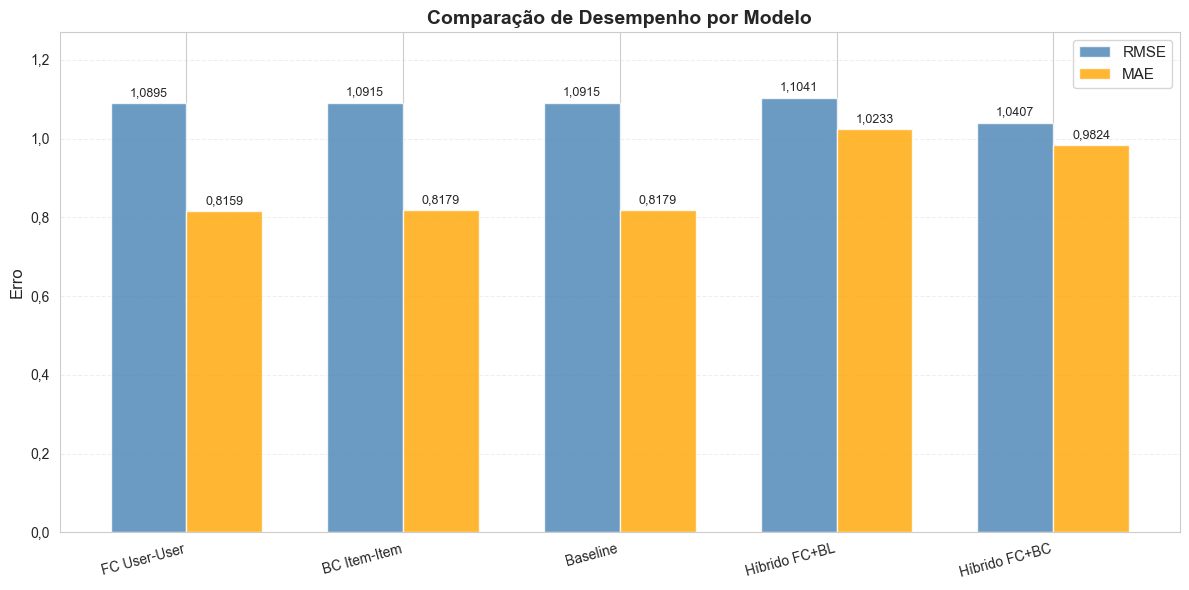


Gerando boxplot de erros...
  ✓ Gráfico salvo: comparacao_modelos_boxplot.png


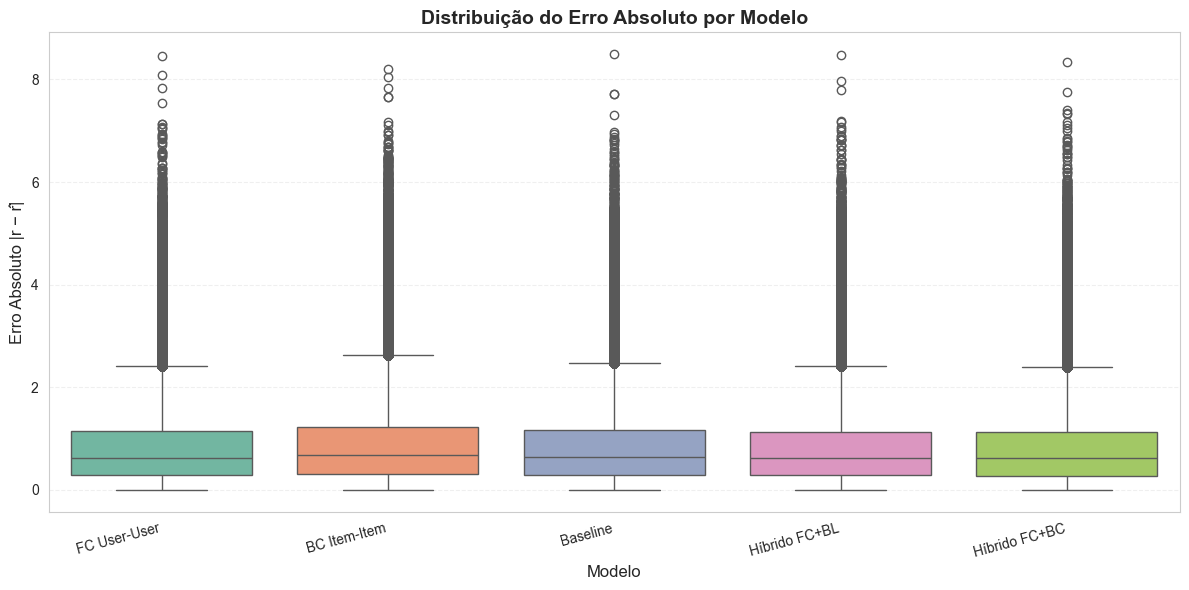


TABELA COMPARATIVA

       Modelo     RMSE      MAE  Erro Médio  Erro Mediano  Erro Std
 FC User-User 1.089512 0.815884    0.818069      0.626592  0.722695
 BC Item-Item 1.091489 0.817878    0.887661      0.678312  0.787354
     Baseline 1.091489 0.817878    0.835240      0.638136  0.737263
Híbrido FC+BL 1.104143 1.023256    0.817131      0.624857  0.724163
Híbrido FC+BC 1.040704 0.982393    0.811343      0.614727  0.726019

🏆 MELHOR MODELO: Híbrido FC+BC
   RMSE: 1.0407
   MAE:  0.9824

✓ DataFrame salvo: df_comparacao_completa

✅ GRÁFICOS COMPARATIVOS COMPLETOS!


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("GRÁFICOS COMPARATIVOS - TODOS OS MODELOS")
print("="*80)

# ============================================================================
# 1. DEFINIR MODELOS E PREDIÇÕES
# ============================================================================

modelos_disponiveis = {}

if 'y_pred_fc' in dir() and 'rmse_fc' in dir() and 'mae_fc' in dir():
    modelos_disponiveis['FC User-User'] = {
        'y_pred': y_pred_fc,
        'rmse': rmse_fc,
        'mae': mae_fc
    }
    print("✓ FC User-User encontrado")

if 'y_pred_bc' in dir() and 'rmse_bc' in dir() and 'mae_bc' in dir():
    modelos_disponiveis['BC Item-Item'] = {
        'y_pred': y_pred_bc,
        'rmse': rmse_bc,
        'mae': mae_bc
    }
    print("✓ BC Item-Item encontrado")

if 'y_pred_bl' in dir() and 'rmse_bl' in dir() and 'mae_bl' in dir():
    modelos_disponiveis['Baseline'] = {
        'y_pred': y_pred_bl,
        'rmse': rmse_bl,
        'mae': mae_bl
    }
    print("✓ Baseline encontrado")

# Para híbridos - verificar se são listas ou escalares
BETA_GRAFICO = 0.7  # Definir o beta desejado para o gráfico

# Híbrido FC+BL
if 'preds_fc_bl' in dir() and 'rmse_fc_bl' in dir() and 'mae_fc_bl' in dir():
    # Verificar se são listas (múltiplos betas) ou escalares (beta único)
    if isinstance(rmse_fc_bl, (list, np.ndarray)):
        # É lista - pegar o índice correspondente ao beta
        if BETA_GRAFICO in beta_values:
            idx_beta = beta_values.index(BETA_GRAFICO)
            y_pred_fc_bl_grafico = preds_fc_bl[BETA_GRAFICO]
            rmse_val = rmse_fc_bl[idx_beta]
            mae_val = mae_fc_bl[idx_beta]
        else:
            print(f"⚠️ Beta {BETA_GRAFICO} não encontrado, usando primeiro valor")
            y_pred_fc_bl_grafico = list(preds_fc_bl.values())[0]
            rmse_val = rmse_fc_bl[0]
            mae_val = mae_fc_bl[0]
    else:
        # É escalar - usar direto
        y_pred_fc_bl_grafico = preds_fc_bl.get(BETA_GRAFICO, list(preds_fc_bl.values())[0])
        rmse_val = rmse_fc_bl
        mae_val = mae_fc_bl
    
    modelos_disponiveis[f'Híbrido FC+BL'] = {
        'y_pred': y_pred_fc_bl_grafico,
        'rmse': rmse_val,
        'mae': mae_val
    }
    print(f"✓ Híbrido FC+BL encontrado")

# Híbrido FC+BC
if 'preds_fc_bc' in dir() and 'rmse_fc_bc' in dir() and 'mae_fc_bc' in dir():
    if isinstance(rmse_fc_bc, (list, np.ndarray)):
        if BETA_GRAFICO in beta_values:
            idx_beta = beta_values.index(BETA_GRAFICO)
            y_pred_fc_bc_grafico = preds_fc_bc[BETA_GRAFICO]
            rmse_val = rmse_fc_bc[idx_beta]
            mae_val = mae_fc_bc[idx_beta]
        else:
            print(f"⚠️ Beta {BETA_GRAFICO} não encontrado, usando primeiro valor")
            y_pred_fc_bc_grafico = list(preds_fc_bc.values())[0]
            rmse_val = rmse_fc_bc[0]
            mae_val = mae_fc_bc[0]
    else:
        y_pred_fc_bc_grafico = preds_fc_bc.get(BETA_GRAFICO, list(preds_fc_bc.values())[0])
        rmse_val = rmse_fc_bc
        mae_val = mae_fc_bc
    
    modelos_disponiveis[f'Híbrido FC+BC'] = {
        'y_pred': y_pred_fc_bc_grafico,
        'rmse': rmse_val,
        'mae': mae_val
    }
    print(f"✓ Híbrido FC+BC encontrado")

print(f"\nTotal de modelos: {len(modelos_disponiveis)}")

if len(modelos_disponiveis) < 2:
    print("⚠️ Precisa de pelo menos 2 modelos!")
else:
    y_true = y_true_fc if 'y_true_fc' in dir() else test_df['Rating'].values
    
    # ========================================================================
    # 2. GRÁFICO 1: BARPLOT - RMSE E MAE
    # ========================================================================
    
    print("\nGerando gráfico de barras...")
    
    model_names = list(modelos_disponiveis.keys())
    rmse_vals = [modelos_disponiveis[m]['rmse'] for m in model_names]
    mae_vals = [modelos_disponiveis[m]['mae'] for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, rmse_vals, width, label='RMSE', color='steelblue', alpha=0.8)
    rects2 = ax.bar(x + width/2, mae_vals, width, label='MAE', color='orange', alpha=0.8)
    
    ax.set_ylabel('Erro', fontsize=12)
    ax.set_title('Comparação de Desempenho por Modelo', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    labels1 = [f"{v:.4f}".replace('.', ',') for v in rmse_vals]
    labels2 = [f"{v:.4f}".replace('.', ',') for v in mae_vals]
    
    ax.bar_label(rects1, labels=labels1, padding=3, fontsize=9)
    ax.bar_label(rects2, labels=labels2, padding=3, fontsize=9)
    
    max_val = max(max(rmse_vals), max(mae_vals))
    ax.set_ylim(0, max_val * 1.15)
    
    plt.tight_layout()
    plt.savefig('images/comparacao_modelos_barplot.png', dpi=300, bbox_inches='tight')
    print("  ✓ Gráfico salvo: comparacao_modelos_barplot.png")
    plt.show()
    
    # ========================================================================
    # 3. GRÁFICO 2: BOXPLOT - DISTRIBUIÇÃO DE ERROS
    # ========================================================================
    
    print("\nGerando boxplot de erros...")
    
    error_data = []
    
    for model_name in model_names:
        y_pred = modelos_disponiveis[model_name]['y_pred']
        
        valid_mask = ~np.isnan(y_pred)
        abs_errors = np.abs(y_true[valid_mask] - y_pred[valid_mask])
        
        for err in abs_errors:
            error_data.append({
                'Modelo': model_name,
                'Erro Absoluto': err
            })
    
    error_df = pd.DataFrame(error_data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(
        data=error_df,
        x='Modelo',
        y='Erro Absoluto',
        palette='Set2',
        ax=ax
    )
    
    ax.set_title('Distribuição do Erro Absoluto por Modelo', fontsize=14, fontweight='bold')
    ax.set_ylabel('Erro Absoluto |r − r̂|', fontsize=12)
    ax.set_xlabel('Modelo', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('images/comparacao_modelos_boxplot.png', dpi=300, bbox_inches='tight')
    print("  ✓ Gráfico salvo: comparacao_modelos_boxplot.png")
    plt.show()
    
    # ========================================================================
    # 4. TABELA COMPARATIVA
    # ========================================================================
    
    print("\n" + "="*80)
    print("TABELA COMPARATIVA")
    print("="*80)
    
    df_comparacao_final = pd.DataFrame({
        'Modelo': model_names,
        'RMSE': rmse_vals,
        'MAE': mae_vals
    })
    
    for i, model_name in enumerate(model_names):
        y_pred = modelos_disponiveis[model_name]['y_pred']
        valid_mask = ~np.isnan(y_pred)
        abs_errors = np.abs(y_true[valid_mask] - y_pred[valid_mask])
        
        df_comparacao_final.loc[i, 'Erro Médio'] = abs_errors.mean()
        df_comparacao_final.loc[i, 'Erro Mediano'] = np.median(abs_errors)
        df_comparacao_final.loc[i, 'Erro Std'] = abs_errors.std()
    
    print()
    print(df_comparacao_final.to_string(index=False))
    
    best_idx = df_comparacao_final['RMSE'].idxmin()
    print(f"\n🏆 MELHOR MODELO: {df_comparacao_final.loc[best_idx, 'Modelo']}")
    print(f"   RMSE: {df_comparacao_final.loc[best_idx, 'RMSE']:.4f}")
    print(f"   MAE:  {df_comparacao_final.loc[best_idx, 'MAE']:.4f}")
    
    df_comparacao_completa = df_comparacao_final.copy()
    print("\n✓ DataFrame salvo: df_comparacao_completa")
    
    print("\n" + "="*80)
    print("✅ GRÁFICOS COMPARATIVOS COMPLETOS!")
    print("="*80)

In [117]:
df_comparison.columns

Index(['Beta', 'FC+BL_RMSE', 'FC+BC_RMSE', 'FC+BL_MAE', 'FC+BC_MAE',
       'FC+BL_Prec', 'FC+BC_Prec', 'FC+BL_Rec', 'FC+BC_Rec'],
      dtype='object')

In [126]:
import numpy as np
import matplotlib.pyplot as plt

beta = 0.7  # Definir o beta usado nos híbridos

# colunas do df_comparison: ['Beta', 'FC+BL_RMSE', 'FC+BC_RMSE', 'FC+BL_MAE', 'FC+BC_MAE',
                           # 'FC+BL_Prec', 'FC+BC_Prec', 'FC+BL_Rec', 'FC+BC_Rec']

rmse_fc_bc = df_comparison[df_comparison['Beta'] == beta]['FC+BC_RMSE'].values[0]
mae_fc_bc  = df_comparison[df_comparison['Beta'] == beta]['FC+BC_MAE'].values[0]

precision_fc_bc = df_comparison[df_comparison['Beta'] == beta]['FC+BC_Prec'].values[0]
recall_fc_bc    = df_comparison[df_comparison['Beta'] == beta]['FC+BC_Rec'].values[0]

rmse_fc_bl = df_comparison[df_comparison['Beta'] == beta]['FC+BL_RMSE'].values[0]
mae_fc_bl  = df_comparison[df_comparison['Beta'] == beta]['FC+BL_MAE'].values[0]

precision_fc_bl = df_comparison[df_comparison['Beta'] == beta]['FC+BL_Prec'].values[0]
recall_fc_bl    = df_comparison[df_comparison['Beta'] == beta]['FC+BL_Rec'].values[0]

model_names = [
    'FC User-User',
    'Baseline',
    'BC Item-Item',
    'Híbrido FC+BL',
    'Híbrido FC+BC'
]

rmse_vals = [
    rmse_fc,
    rmse_bl,
    rmse_bc,
    rmse_fc_bl,
    rmse_fc_bc
]

mae_vals = [
    mae_fc,
    mae_bl,
    mae_bc,
    mae_fc_bl,
    mae_fc_bc
]

precision_vals = [
    precision_fc,
    precision_bl,
    precision_bc,
    precision_fc_bl,
    precision_fc_bc
]

recall_vals = [
    recall_fc,
    recall_bl,
    recall_bc,
    recall_fc_bl,
    recall_fc_bc
]

x = np.arange(len(model_names))
width = 0.35



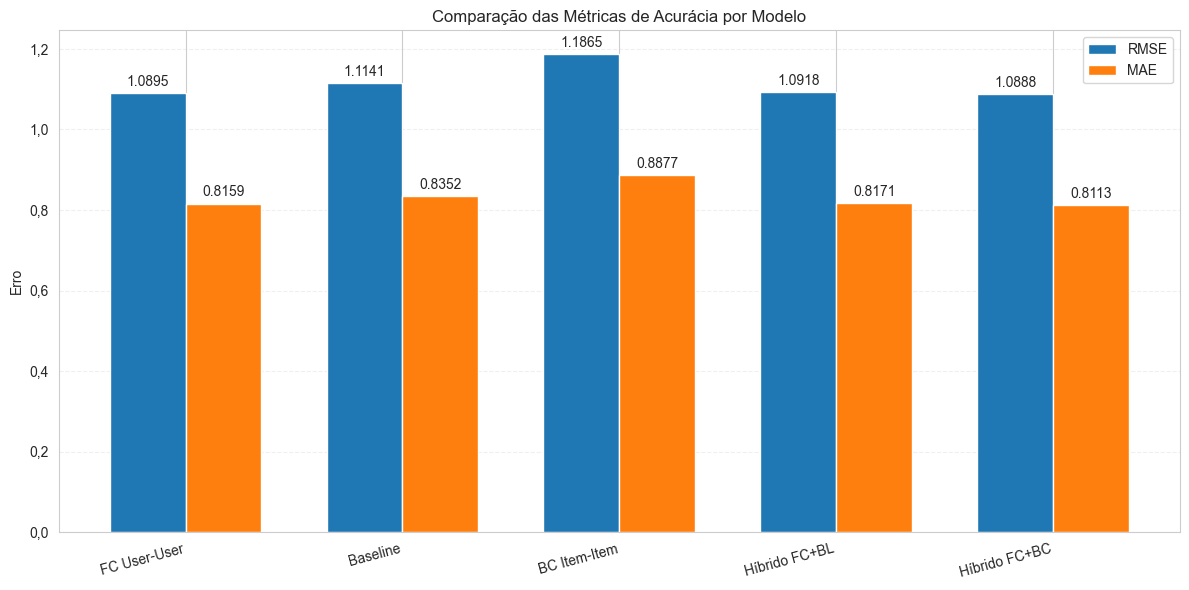

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))

bars_rmse = ax.bar(x - width/2, rmse_vals, width, label='RMSE')
bars_mae  = ax.bar(x + width/2, mae_vals,  width, label='MAE')

ax.set_ylabel('Erro')
ax.set_title('Comparação das Métricas de Acurácia por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# rótulos
ax.bar_label(bars_rmse, fmt='%.4f', padding=3)
ax.bar_label(bars_mae,  fmt='%.4f', padding=3)

plt.tight_layout()
plt.savefig('images/comparacao_modelos_acuracia.png', dpi=300, bbox_inches='tight')
plt.show()


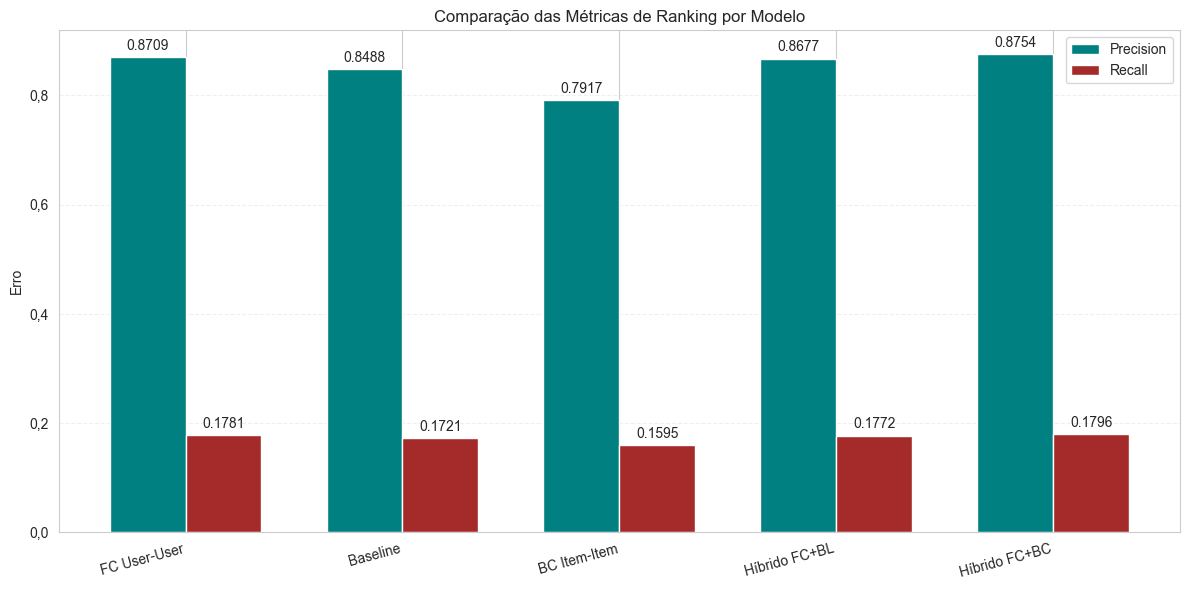

In [143]:
fig, ax = plt.subplots(figsize=(12, 6))

bars_prec = ax.bar(x - width/2, precision_vals, width, label='Precision', color='teal')
bars_rec  = ax.bar(x + width/2, recall_vals,  width, label='Recall', color='brown')

ax.set_ylabel('Erro')
ax.set_title('Comparação das Métricas de Ranking por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# rótulos
ax.bar_label(bars_prec, fmt='%.4f', padding=3)
ax.bar_label(bars_rec,  fmt='%.4f', padding=3)

plt.tight_layout()
plt.savefig('images/comparacao_modelos_ranking.png', dpi=300, bbox_inches='tight')
plt.show()


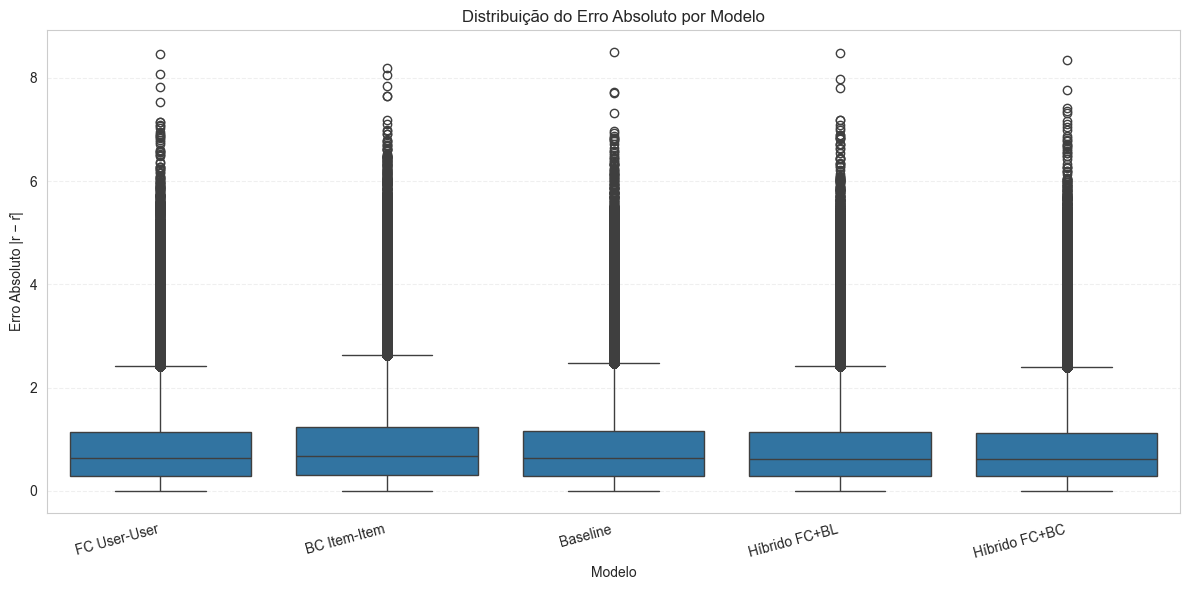

In [91]:
import pandas as pd
import seaborn as sns

beta = 0.7  # Defina o valor de beta desejado

predicoes = {
    'FC User-User': y_pred_fc,
    'BC Item-Item': y_pred_bc,
    'Baseline': y_pred_bl,
    'Híbrido FC+BL': preds_fc_bl[beta],
    'Híbrido FC+BC': preds_fc_bc[beta]
}

dados = []

for nome, y_pred in predicoes.items():
    mask = ~np.isnan(y_pred)
    erros = np.abs(y_true[mask] - y_pred[mask])
    
    for e in erros:
        dados.append({
            'Modelo': nome,
            'Erro Absoluto': e
        })

df_box = pd.DataFrame(dados)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_box,
    x='Modelo',
    y='Erro Absoluto'
)

plt.title('Distribuição do Erro Absoluto por Modelo')
plt.ylabel('Erro Absoluto |r − r̂|')
plt.xlabel('Modelo')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparacao_modelos_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [92]:
beta

0.7